<a href="https://colab.research.google.com/github/sotudian/BL_Exp/blob/main/New_List_Width_Analysis_GEP_Jan_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jan 2024
# **Analyze the samples in 4 group and try to find genes that are stable and slo new featres**

In [1]:
pip install pyreadr gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import pyreadr
import random
from sklearn import preprocessing
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import os
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
#from scipy import stats
import statsmodels.api as sm
# import pylab as pl
import json
import copy
import pickle
from sklearn.decomposition import PCA
import jax
import jax.numpy as jnp
import torch
from IPython.display import display, HTML
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import ndcg_score, average_precision_score
from scipy.stats import spearmanr, kendalltau
import gseapy as gp
from gseapy import enrichment_map
from gseapy import dotplot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve







# |||||||||| **Main Parameters**   |||||||||||||||||||||||||||||||||||

In [3]:
Naive_cols = ['FC_Small21','FC_Small22','FC_Small23', 'FC_Small24','FC_Small25','FC_Small26','FC_Small27','FC_Small28','FC_Small29','FC_Small30']


OP = {
          "Model_type" : "Rank_ndcg",  #  Rank_map    Rank_ndcg
          "Save_training_flag": False,
          "Name_Save_load_Data":"Name_will_be_completed_line19",
          "Drive_Dir":"/content/drive/MyDrive/Second_Project_GeneExpression_Prediction/",
          "Save_Folder_Name": 'Ranking_Result_',
          "Main_Dir": '/content/'
          }

OP["Name_Save_load_Data"] = "ML_"+OP["Model_type"]+"_GEP_"

OP["Save_Folder_Name"] = OP["Save_Folder_Name"]+OP["Model_type"]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# |||||||||| **Functions**   |||||||||||||||||||||||||||||||||||

In [5]:

def Train_Func(X_train,Y_Train,clf,Model_type,Qid):
      if OP["Model_type"] == "Rank_map":
          clf.fit(X_train,Y_Train, qid=Qid)
      elif OP["Model_type"] == "Rank_ndcg":
          clf.fit(X_train,Y_Train, qid=Qid)
      return clf


def Ranking_Evaluation(GT_labels,Pred_scores,GT_Rank,Pred_Rank):
    #GT_labels =   TMP_Df['GT']
    #Pred_scores = TMP_Df['My_Pred']    OR    TMP_Df['Naive_Pred']
    #GT_Rank = TMP_Df['GT_Rank']
    #Pred_Rank = TMP_Df['My_Pred_Rank']   or   TMP_Df['Naive_Rank']
    Eval_Dic = {}
    Eval_Dic['NDCG'] =     ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) )
    Eval_Dic['NDCG@10'] =  ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =10)
    Eval_Dic['NDCG@25'] =  ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =25)
    Eval_Dic['NDCG@50'] =  ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =50)
    Eval_Dic['NDCG@100'] = ndcg_score(np.asarray([GT_labels]).astype(int)   , np.asarray([Pred_scores]) , k =100)

    Eval_Dic['AH@10'] = sum(Pred_Rank.head(10) <= 10)
    Eval_Dic['AH@25'] = sum(Pred_Rank.head(25) <= 25)
    Eval_Dic['AH@50'] = sum(Pred_Rank.head(50) <= 50)

    Eval_Dic['Spearman'] = spearmanr(GT_Rank, Pred_Rank).correlation
    Eval_Dic['Spearman@25'] = spearmanr(GT_Rank[:25], Pred_Rank[:25]).correlation
    Eval_Dic['Spearman@100'] = spearmanr(GT_Rank[:100], Pred_Rank[:100]).correlation

    Eval_Dic['KendallTau'] = kendalltau(GT_Rank, Pred_Rank).correlation
    Eval_Dic['KendallTau@25'] = kendalltau(GT_Rank[:25], Pred_Rank[:25]).correlation
    Eval_Dic['KendallTau@100'] = kendalltau(GT_Rank[:100], Pred_Rank[:100]).correlation

    return Eval_Dic



def Test_Eval_Func(DF_Test,clf,Model_type,Naive_cols):
    predictions_dict = {}
    Perf_Rankning_scores = {}
    Perf_Rankning_scores['Num_samples'] = 0
    Perf_Naive_scores = {}
    Perf_Naive_scores['Num_samples'] = 0
    # add random value - duplicates
    np.random.seed(2023)

    Random_Val_Added = np.random.uniform(0, 0.000001, size=DF_Test[DF_Test["Qid"] == pd.unique(DF_Test["Qid"])[1]].shape[0])
    for id in pd.unique(DF_Test["Qid"]):
              xtest = DF_Test[DF_Test["Qid"] == id].drop(['Label',"Qid","Gene_name","Label_GE"], axis=1)
              ytest = DF_Test[DF_Test["Qid"] == id].loc[:,'Label']
              Actual_Gene_Exp_Label = DF_Test[DF_Test["Qid"] == id].loc[:,'Label_GE']


              ytest_pred_score = clf.predict(xtest.values)
              y_pred_Naive = np.sum(xtest[Naive_cols], axis=1)

              # add random value - duplicates
              ytest_pred_score = ytest_pred_score + Random_Val_Added
              y_pred_Naive = y_pred_Naive + Random_Val_Added
              Actual_Gene_Exp_Label = Actual_Gene_Exp_Label + Random_Val_Added
              ytest = ytest + Random_Val_Added

              M_GT_Rank = Actual_Gene_Exp_Label.rank(ascending=False,method='first')
              M_My_Pred_Rank = list(pd.DataFrame(ytest_pred_score.tolist()).rank(ascending=False,method='first').loc[:,0])
              M_Naive_Pred = y_pred_Naive.tolist()
              M_Naive_Rank = list(pd.DataFrame(y_pred_Naive.tolist()).rank(ascending=False,method='first').loc[:,0])

              TMP_Df = pd.DataFrame({ 'Gene':list(DF_Test[DF_Test["Qid"] == id].loc[:,'Gene_name']),
                                      'Gene_Exp_Label':list(Actual_Gene_Exp_Label),
                                      'GT': ytest,
                                      'GT_Rank': M_GT_Rank,
                                      'My_Pred': ytest_pred_score,
                                      'My_Pred_Rank': M_My_Pred_Rank,
                                      'Naive_Pred': M_Naive_Pred,
                                      'Naive_Rank': M_Naive_Rank,
                                      })

              TMP_Df = TMP_Df.sort_values('Gene_Exp_Label',ascending = False)






              predictions_dict[id] = TMP_Df
              print(f'\n######## Qid {id} - sample: {QID_Dic[id]}  - Results:\n')
              Perf_Ranking = Ranking_Evaluation(TMP_Df['GT'], TMP_Df['My_Pred'],TMP_Df['GT_Rank'], TMP_Df['My_Pred_Rank'])
              print('OOO Ranking model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Ranking[x],3)) for x in Perf_Ranking])+   ' \n')


              Perf_Naive = Ranking_Evaluation(TMP_Df['GT'], TMP_Df['Naive_Pred'],TMP_Df['GT_Rank'], TMP_Df['Naive_Rank'])
              print('OOO Naive model =====>      ' +"   ||   ".join([x+" = "+str(round(Perf_Naive[x],3)) for x in Perf_Naive])+   ' \n')
              for k in Perf_Ranking:
                  if k in Perf_Rankning_scores:
                      Perf_Rankning_scores[k] += Perf_Ranking[k]
                      Perf_Naive_scores[k] += Perf_Naive[k]
                  else:
                      Perf_Rankning_scores[k] = Perf_Ranking[k]
                      Perf_Naive_scores[k] = Perf_Naive[k]
              Perf_Rankning_scores['Num_samples'] += 1
              Perf_Naive_scores['Num_samples'] += 1

    print('\n################################\n### Average of All Qids :\n################################')
    print('OOO Averge Performance Ranking model =====>      ' +"   ||   ".join(["Average "+x+" = "+str(round(Perf_Rankning_scores[x]/Perf_Rankning_scores['Num_samples'],3)) for x in Perf_Rankning_scores if x !='Num_samples'])+   ' \n')
    print('OOO Averge Performance Naive model   =====>      ' +"   ||   ".join(["Average "+x+" = "+str(round(Perf_Naive_scores[x]/Perf_Naive_scores['Num_samples'],3)) for x in Perf_Naive_scores if x !='Num_samples'])+   ' \n')
    predictions_dict['Perf_Rankning_scores'] = Perf_Rankning_scores
    predictions_dict['Perf_Naive_scores'] = Perf_Naive_scores
    return predictions_dict




def PreProcessing_Steps(Raw_Data,Except_col):
      labels = list(Raw_Data['Label'])
      QIDs = list(Raw_Data[Except_col[0]])
      Gene_name = list(Raw_Data[Except_col[1]])
      Raw_Data = Raw_Data.drop(['Label',Except_col[0],Except_col[1]], axis=1)
      # Normalize Continious features
      scaler = preprocessing.StandardScaler()
      columns_to_normalize = Raw_Data.columns
      Raw_Data[columns_to_normalize] = scaler.fit_transform(Raw_Data[columns_to_normalize])
      del scaler,columns_to_normalize
      Raw_Data = Raw_Data.assign(Label=labels)
      Raw_Data = Raw_Data.assign(Qid=QIDs)
      Raw_Data = Raw_Data.assign(Gene_name=Gene_name)
      #Raw_Data['Label'] = labels
      # Fill NAs
      Raw_Data.fillna(Raw_Data.median(numeric_only= True), inplace=True)
      Raw_Data = Raw_Data.reset_index(drop=True)
      return Raw_Data




def LABELING_Method(Raw_Data,Method):
    if Method == 'binary':
          threshold = Raw_Data['Label'].quantile(0.90)
          Raw_Data['Label'] = (Raw_Data['Label'] >= threshold).astype(int)
    elif Method == '6_labels':
          AA = Raw_Data['Label']
          T1 = AA.quantile(0.75)
          T2 = AA.quantile(0.80)
          T3 = AA.quantile(0.85)
          T4 = AA.quantile(0.90)
          T5 = AA.quantile(0.95)
          labels = [0, 1, 2, 3, 4, 5]
          AA = pd.cut(AA, bins=[-float('inf'), T1, T2, T3, T4, T5, float('inf')], labels=labels)
          Raw_Data['Label'] = AA
    elif Method == '3_labels':
          AA = Raw_Data['Label']
          T1 = AA.quantile(0.90)
          T2 = AA.quantile(0.95)
          labels = [0, 1, 2]
          AA = pd.cut(AA, bins=[-float('inf'), T1, T2, float('inf')], labels=labels)
          Raw_Data['Label'] = AA
    elif Method == 'scores':
          AA = Raw_Data['Label']
          Raw_Data['Label'] = round(AA)
    return Raw_Data






def PLOTTING(All_Performnace_Matrix_DF):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Plot the first subplot on the left side
    axes[0].plot(All_Performnace_Matrix_DF["Number_of_Training_Samples"], All_Performnace_Matrix_DF["F1_SCORE"], label="F1_SCORE")
    axes[0].set_xlabel("Number of Training Samples")
    axes[0].set_ylabel("F1 Score")
    axes[0].legend()

    # Plot the second subplot on the right side
    axes[1].plot(All_Performnace_Matrix_DF["Number_of_Training_Samples"], All_Performnace_Matrix_DF["AUC"], label="AUC", color='green')
    axes[1].set_xlabel("Number of Training Samples")
    axes[1].set_ylabel("AUC")
    axes[1].legend()

    # Display the figure with both subplots
    plt.tight_layout()
    plt.show()





def Feature_Importance_Plots(ML_Model,Model_type,Feature_Types):
      feature_names = ML_Model.feature_names_in_.tolist()
      feature_importance = (ML_Model.feature_importances_).tolist()
      total_subplots = len(Feature_Types)
      fig, axes = plt.subplots(total_subplots, 1, figsize=(6, 8 * total_subplots))


      for j in range(total_subplots):

          indices = [i for i, element in enumerate(feature_names) if element.startswith(Feature_Types[j])]
          features_to_plot = [feature_names[s] for s in indices]
          scores_to_plot = [feature_importance[s] for s in indices]

          ax = axes[j]
          ax.barh(features_to_plot, scores_to_plot,color='red')
          ax.set_xlabel(OP["Model_type"]+'-Model Feature Importance')
          ax.set_ylabel('Features')
          ax.set_title(OP["Model_type"]+f'-Feature Importance - Features {Feature_Types[j]}')
          ax.set_xlim([min(feature_importance), max(feature_importance)])
          ax.set_yticklabels(features_to_plot, fontsize=7)  # You can adjust the fontsize as needed

      plt.tight_layout()  # Ensure proper spacing between subplots
      plt.show()

def Deploy_Ranking_Model_Prediction_Func(DF_Test,clf,Model_type,Naive_cols):
    predictions_dict = {}
    np.random.seed(2023)
    Random_Val_Added = np.random.uniform(0, 0.000001, size=DF_Test[DF_Test["Qid"] == pd.unique(DF_Test["Qid"])[1]].shape[0])
    for id in pd.unique(DF_Test["Qid"]):
              xtest = DF_Test[DF_Test["Qid"] == id].drop(['Label',"Qid","Gene_name","Label_GE"], axis=1)
              ytest = DF_Test[DF_Test["Qid"] == id].loc[:,'Label']
              Actual_Gene_Exp_Label = DF_Test[DF_Test["Qid"] == id].loc[:,'Label_GE']

              ytest_pred_score = clf.predict(xtest.values)
              y_pred_Naive = np.sum(xtest[Naive_cols], axis=1)

              # add random value - duplicates
              ytest_pred_score = ytest_pred_score + Random_Val_Added
              y_pred_Naive = y_pred_Naive + Random_Val_Added
              Actual_Gene_Exp_Label = Actual_Gene_Exp_Label + Random_Val_Added
              ytest = ytest + Random_Val_Added

              M_GT_Rank = Actual_Gene_Exp_Label.rank(ascending=False,method='first')
              M_My_Pred_Rank = list(pd.DataFrame(ytest_pred_score.tolist()).rank(ascending=False,method='first').loc[:,0])
              M_Naive_Pred = y_pred_Naive.tolist()
              M_Naive_Rank = list(pd.DataFrame(y_pred_Naive.tolist()).rank(ascending=False,method='first').loc[:,0])

              TMP_Df = pd.DataFrame({ 'Gene':list(DF_Test[DF_Test["Qid"] == id].loc[:,'Gene_name']),
                                      'Gene_Exp_Label':list(Actual_Gene_Exp_Label),
                                      'GT': ytest,
                                      'GT_Rank': M_GT_Rank,
                                      'My_Pred': ytest_pred_score,
                                      'My_Pred_Rank': M_My_Pred_Rank,
                                      'Naive_Pred': M_Naive_Pred,
                                      'Naive_Rank': M_Naive_Rank,
                                      })

              TMP_Df = TMP_Df.sort_values('Gene_Exp_Label',ascending = False)
              predictions_dict[id] = TMP_Df
    return predictions_dict






def Train_Eval_Classification_Model(Main_DF,Model_name, Class_Model_Parameters):
        X = Main_DF.drop("Label", axis=1)
        y = Main_DF["Label"]
        logreg_model = LogisticRegression(**Class_Model_Parameters)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []
        f1_scores = []
        accuracy_scores = []
        tpr_list = []
        fpr_list = []
        thresholds_list = []

        # Loop through each fold
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            logreg_model.fit(X_train, y_train)  # Train the logistic regression model
            y_pred_prob = logreg_model.predict_proba(X_test)[:, 1] # Make predictions on the test set
            # Calculate AUC
            auc = roc_auc_score(y_test, y_pred_prob)
            auc_scores.append(auc)
            # Calculate F1 score
            f1 = f1_score(y_test, logreg_model.predict(X_test))
            f1_scores.append(f1)
            # Calculate accuracy
            accuracy = accuracy_score(y_test, logreg_model.predict(X_test))
            accuracy_scores.append(accuracy)
            # Calculate ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            tpr_list.append(tpr)
            fpr_list.append(fpr)
            thresholds_list.append(thresholds)
        # Plot ROC curves for each fold
        plt.figure(figsize=(8, 8))
        for i in range(len(tpr_list)):
            plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} - (AUC:{round(auc_scores[i],3)} | F1:{round(f1_scores[i],3)} | ACC:{round(accuracy_scores[i],3)})')

        # Plot the mean ROC curve (interpolate to have the same number of points)
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr_list[i], tpr_list[i]) for i in range(len(tpr_list))], axis=0)

        # Calculate and print mean AUC, F1 score, and accuracy
        mean_auc = np.mean(auc_scores)
        mean_f1 = np.mean(f1_scores)
        mean_accuracy = np.mean(accuracy_scores)

        plt.plot(mean_fpr, mean_tpr, label=f'Mean - (AUC:{round(mean_auc,3)} | F1:{round(mean_f1,3)} | ACC:{round(mean_accuracy,3)})', color='black', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for each Fold and Mean - '+Model_name.replace('My_Pred_Rank','Ranking_Model').replace('_Rank','_Model'))
        plt.legend()
        plt.show()



def Data_analysis_Plot(Selcted_samples_DF,Selected_Study_Name_Samples,Selected_Gene_name,Feature_Types,max_y):
      # Create subplots
      fig, axs = plt.subplots(nrows=len(Selected_Study_Name_Samples), ncols=len(Feature_Types), figsize=(25, 2*len(Selected_Study_Name_Samples)))

      # Iterate over each study
      for i, ss in enumerate(Selected_Study_Name_Samples):
          ss_QID = [kk for kk in QID_Dic if QID_Dic[kk][0] == ss][0]
          Raw_ALL_Data_i = Raw_ALL_Data[Raw_ALL_Data['Qid'] == ss_QID]
          Raw_ALL_Data_i = Raw_ALL_Data_i.reset_index(drop=True)
          AA = Selcted_samples_DF[Selcted_samples_DF['study_name'] == ss]

          selected_row = Raw_ALL_Data_i[Raw_ALL_Data_i['Gene_name'] == Selected_Gene_name]
          for j in range(len(Feature_Types)):
              # Select columns starting with 'FLC_'
              flc_columns = selected_row.filter(regex='^'+Feature_Types[j], axis=1)

              # Plot on the corresponding subplot
              axs[i, j].bar(list(flc_columns.keys()), list(flc_columns.values[0]), color='maroon', width=0.4)
              #axs[i, j].set_xticks(rotation=90)
              axs[i, j].set_ylabel("Values")
              if i == len(Selected_Study_Name_Samples) - 1:
                  axs[i, j].set_xticks(range(len(list(flc_columns.keys()))))
                  axs[i, j].set_xticklabels(list(flc_columns.keys()), rotation=90)
              else:
                  axs[i, j].set_xticks([])

              axs[i, j].set_title(f'Gene= {Selected_Gene_name} - Sample: {AA.cancer_type.values[0]}-{AA.study_name.values[0]} <> HER2: {AA.HER2.values[0]} <> ctDNA: {AA.ctDNA.values[0]}')
              axs[i, j].set_ylim(0, max_y)

      # Adjust layout
      plt.tight_layout()
      plt.show()



# |||||||||| **Sample Selection + Parameters**   |||||||||||||||||||||||||||||||||||

In [6]:
removed_cols = ['Gene_id','chr','start','end','TSS_s_samll','TSS_e_samll']
Cancer_Types = [ 'Healthy']    #  'Breast','Prostate','NSCLC','Colorectal'  'Healthy
folder_name = 'Data_Healthy_ListWidth/'  # Data_Healthy_ListWidth     Final_Data_All_Cancer_Types
prefixes_to_drop = []  #"FL_median_", "GC_Small"

Healthy_GE_Stats_df = pd.read_csv(OP["Drive_Dir"]+'Data/'+'Healthy_GE_Stats_Blood_For_GoogleColab2024.csv')


Healthy_GE_Stats_df.head()



gene_id_no_version gene_name           gene_id.x    chr      start  \
0    ENSG00000000003    TSPAN6  ENSG00000000003.10   chrX   99883667   
1    ENSG00000000005      TNMD   ENSG00000000005.5   chrX   99839799   
2    ENSG00000000419      DPM1   ENSG00000000419.8  chr20   49551404   
3    ENSG00000000457     SCYL3   ENSG00000000457.9   chr1  169818772   
4    ENSG00000000460  C1orf112  ENSG00000000460.12   chr1  169631245   

         end strand  Average_Healthy_GE_fpkm  SD_Healthy_GE_fpkm  \
0   99894988      -                 0.140878            0.028446   
1   99854882      +                 0.009565            0.000992   
2   49575092      -                 3.498215            2.118031   
3  169863408      -                 2.115745            0.813285   
4  169823221      +                 1.404482            1.606411   

            gene_id.y  
0  ENSG00000000003.14  
1   ENSG00000000005.5  
2  ENSG00000000419.12  
3  ENSG00000000457.13  
4  ENSG00000000460.16

In [7]:

print("Load and Process the raw Data ......")
Dir_Add = OP["Drive_Dir"]+'Data/'+folder_name
Data_list = os.listdir(OP["Drive_Dir"]+'Data/'+folder_name)
Data_list = [file for file in Data_list if file.endswith('.feather')]
Data_list = [element for element in Data_list if ((element.split('_cancer_type_')[1].split('_WL_')[0] in Cancer_Types)) ]


#if len(Sample_error_remove)>0:
#    for i in Sample_error_remove:
#      Data_list.remove(i)

Excell_sampels = pd.read_excel(OP["Drive_Dir"]+'Data/Table_S1_with_file_locations.xlsx').drop(columns=['peak_number', 'antibody_vendor', 'source', 'enrichment', 'fragments', 'bam_file', 'rds_file','peak_file', 'bigwig_file', 'fastq1', 'fastq2'])
Excell_sampels= Excell_sampels[Excell_sampels['antibody'] == 'H3K4me3']
Excell_sampels= Excell_sampels[Excell_sampels['cancer_type'].isin(["Breast","Prostate","NSCLC","Colorectal","Healthy"])]
Excell_sampels = Excell_sampels.drop_duplicates(subset='individual_id', keep='first')

Selcted_samples_DF =(Excell_sampels[Excell_sampels['study_name'].isin( [element.split('_study_name_')[1].split('_individual_id_')[0] for element in Data_list])])
print("Number of samples Excell file: ",len((Selcted_samples_DF))," VS Number of samples Data_list: ",len(Data_list))
display(HTML(Selcted_samples_DF.to_html()))



Load and Process the raw Data ......
Number of samples Excell file:  34  VS Number of samples Data_list:  38


In [8]:
display(HTML(pd.DataFrame(Selcted_samples_DF["cancer_type"].value_counts()).to_html()))


# |||||||||| **Data Preprocessing**   |||||||||||||||||||||||||||||||||||

In [9]:

import pyarrow.feather as feather
main_dataframes = []

print("Total samples count: ",len(Data_list))
for ct in Cancer_Types:
    print(ct," cancer - count: ",len([element for element in Data_list if ct in element]))

count = 1
QID_Dic = {}
for file_name in Data_list:
          print(file_name)
          # Read the Feather file
          Data_raw = feather.read_feather(OP["Drive_Dir"]+'Data/'+folder_name+file_name)

          # Convert the string back to a list
          for CCC in [col for col in Data_raw.columns if any(col.startswith(prefix) for prefix in ['FL_Width_List_Small'])]:
              Data_raw[CCC] = Data_raw[CCC].replace('NA', '0', regex=True)
              Data_raw[CCC] = Data_raw[CCC].apply(lambda x: eval(x))

          Data_raw = Data_raw.drop(removed_cols, axis=1)
          # Filter columns that start with prefixes in the list
          columns_to_drop = [col for col in Data_raw.columns if any(col.startswith(prefix) for prefix in prefixes_to_drop)]
          Data_raw.drop(columns=columns_to_drop, inplace=True)
          Data_raw = Data_raw.drop_duplicates(subset='Gene_name', keep=False)


          Data_raw = Data_raw.rename(columns={'Label_GE_fpkm': 'Label'})
          Data_raw['Qid'] = [count] * len(Data_raw)
          QID_Dic[count] = [file_name.split('_study_name_')[1].split('_individual_id')[0], [ct for ct in ['Breast','Prostate','NSCLC','Colorectal', 'Healthy'] if ct in file_name ][0]]

          print("Number of NAs: ",str(Data_raw.isna().sum().sum()))
          print("Impute missing values with the median of the corresponding column....")
          Data_raw = Data_raw.fillna(Data_raw.median(numeric_only=True))
          count += 1
          main_dataframes.append(Data_raw)


Raw_ALL_Data = pd.concat(main_dataframes, ignore_index=True)
Raw_ALL_Data = Raw_ALL_Data.reset_index(drop=True)

Raw_ALL_Data.head(3)

Total samples count:  38
Healthy  cancer - count:  38
Healthy_Analysis_WidthList_DATA_GEP_Num_1_study_name_HP11717Me3R1v01_individual_id_10011717_cancer_type_Healthy_WL_10000_NBins_50_.feather
Number of NAs:  520641
Impute missing values with the median of the corresponding column....
Healthy_Analysis_WidthList_DATA_GEP_Num_10_study_name_HP31645Me3R1_individual_id_10031645_cancer_type_Healthy_WL_10000_NBins_50_.feather
Number of NAs:  520818
Impute missing values with the median of the corresponding column....
Healthy_Analysis_WidthList_DATA_GEP_Num_11_study_name_HP100337_individual_id_10033740_cancer_type_Healthy_WL_10000_NBins_50_.feather
Number of NAs:  438323
Impute missing values with the median of the corresponding column....
Healthy_Analysis_WidthList_DATA_GEP_Num_12_study_name_HP034881_individual_id_10034881_cancer_type_Healthy_WL_10000_NBins_50_.feather
Number of NAs:  394694
Impute missing values with the median of the corresponding column....
Healthy_Analysis_WidthList_DATA_

Gene_name     Label  FLC_P5  FLC_P25  FLC_P50  FLC_P75  FLC_P95  \
0    TSPAN6  0.140878    75.0     75.0     75.0     75.0   75.000   
1      TNMD  0.009565   141.0    171.5    234.0    321.0  430.725   
2       FGR  7.793554   169.7    262.5    304.0    361.0  421.100   

  FL_Width_List_Small1 FL_Width_List_Small2 FL_Width_List_Small3  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                  362   

  FL_Width_List_Small4 FL_Width_List_Small5 FL_Width_List_Small6  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

  FL_Width_List_Small7 FL_Width_List_Small8 FL_Width_List_Small9  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

  FL_Width_List_Small10 FL_Width_List_Small11 FL_Width_List_Small12  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

  FL_Width_List_Small13 FL_Width_List_Small14 FL_Width_List_Small15  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

  FL_Width_List_Small16 FL_Width_List_Small17 FL_Width_List_Small18  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

  FL_Width_List_Small19 FL_Width_List_Small20 FL_Width_List_Small21  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0       (397, 396, 398)                     0   

  FL_Width_List_Small22 FL_Width_List_Small23 FL_Width_List_Small24  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

  FL_Width_List_Small25           FL_Width_List_Small26 FL_Width_List_Small27  \
0                     0                               0                     0   
1                     0                               0                     0   
2                     0  (255, 296, 167, 199, 310, 270)       (360, 317, 292)   

  FL_Width_List_Small28 FL_Width_List_Small29 FL_Width_List_Small30  \
0                    75                     0                     0   
1                     0                     0                     0   
2                   343            (456, 431)                     0   

  FL_Width_List_Small31 FL_Width_List_Small32 FL_Width_List_Small33  \
0                     0                     0                     0   
1                     0                     0                     0   
2            (303, 176)                     0            (299, 376)   

  FL_Width_List_Small34 FL_Width_List_Small35 FL_Width_List_Small36  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                   176   

  FL_Width_List_Small37 FL_Width_List_Small38 FL_Width_List_Small39  \
0                     0                     0                     0   
1                     0                     0                     0   
2            (162, 289)            (307, 305)                     0   

  FL_Width_List_

# **Grouping - Genes **

In [10]:
from itertools import chain
Groups_DF_Dic = {}

Healthy_GE_Stats_df.rename(columns={'gene_name': 'Gene_name'}, inplace=True)
Healthy_GE_Stats_df = Healthy_GE_Stats_df[Healthy_GE_Stats_df['Gene_name'].isin(Raw_ALL_Data[Raw_ALL_Data['Qid'] == list(QID_Dic.keys())[0]].Gene_name)]
Healthy_GE_Stats_df = Healthy_GE_Stats_df.sort_values(by =['Average_Healthy_GE_fpkm'], ascending=False).reset_index(drop=True)



N_groups = 5
nested_list =   [[i]* (round(len(Healthy_GE_Stats_df)/N_groups)-1) for i in range(1,N_groups+1)]
nested_list = list(chain(*nested_list))
nested_list  =  nested_list + [N_groups]*(len(Healthy_GE_Stats_df) - N_groups*(round(len(Healthy_GE_Stats_df)/N_groups)-1))
Healthy_GE_Stats_df['groups'] = nested_list


# Create DataFrames in a for loop
for i in range(1, N_groups + 1):
    Groups_DF_Dic[f'Group_{i}'] = Healthy_GE_Stats_df[Healthy_GE_Stats_df['groups'] == i].sort_values(by =['SD_Healthy_GE_fpkm'], ascending=True).reset_index(drop=True)
    print(f'Group_{i}: ',len(Groups_DF_Dic[f'Group_{i}']))




Groups_DF_Dic['Group_1'].head()


Group_1:  2373
Group_2:  2373
Group_3:  2373
Group_4:  2373
Group_5:  2379


gene_id_no_version Gene_name           gene_id.x    chr      start  \
0    ENSG00000107521      HPS1  ENSG00000107521.14  chr10  100175955   
1    ENSG00000163374    YY1AP1  ENSG00000163374.15   chr1  155629237   
2    ENSG00000196961     AP2A1   ENSG00000196961.8  chr19   50270225   
3    ENSG00000075413     MARK3  ENSG00000075413.13  chr14  103851729   
4    ENSG00000115649    CNPPD1  ENSG00000115649.11   chr2  220036619   

         end strand  Average_Healthy_GE_fpkm  SD_Healthy_GE_fpkm  \
0  100206684      -                 5.495672            0.148357   
1  155658791      -                 5.658419            0.149022   
2   50310370      +                 5.132235            0.169259   
3  103970168      +                 5.268726            0.174673   
4  220042828      -                 5.544147            0.176395   

            gene_id.y  groups  
0  ENSG00000107521.18       1  
1  ENSG00000163374.19       1  
2  ENSG00000196961.12       1  
3  ENSG00000075413.17       1  
4  ENSG00000115649.15       1

# **Every patient - FC per bins**

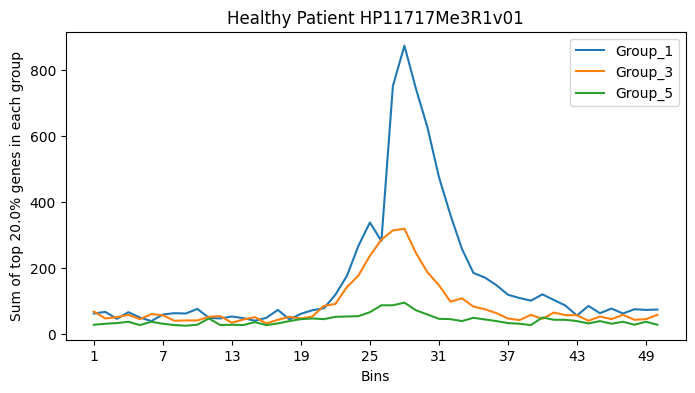

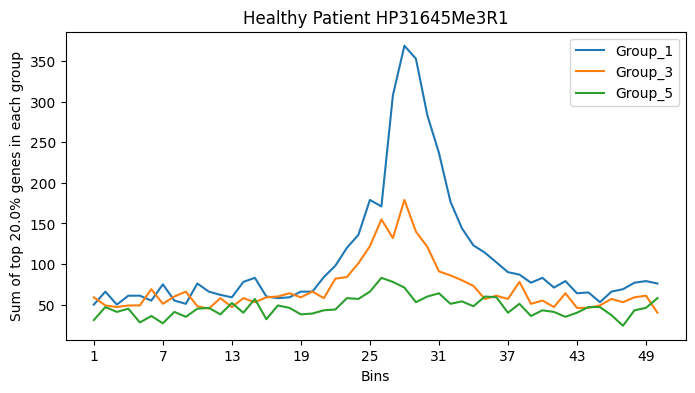

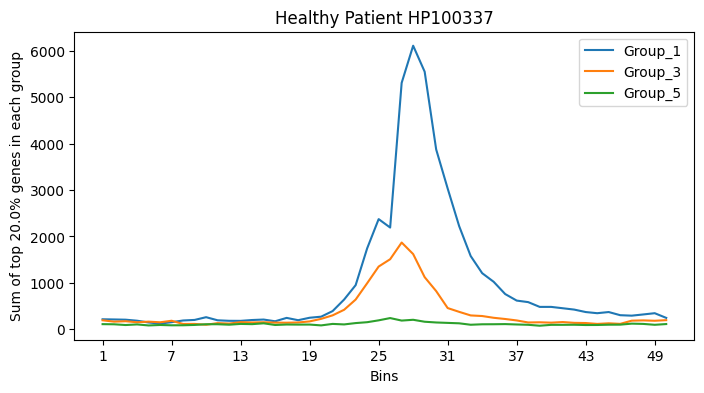

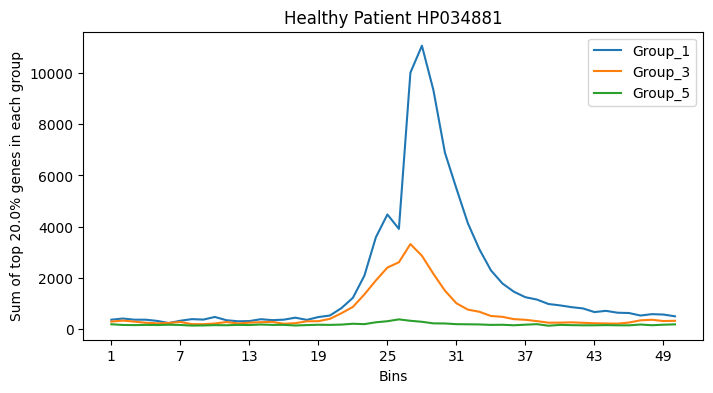

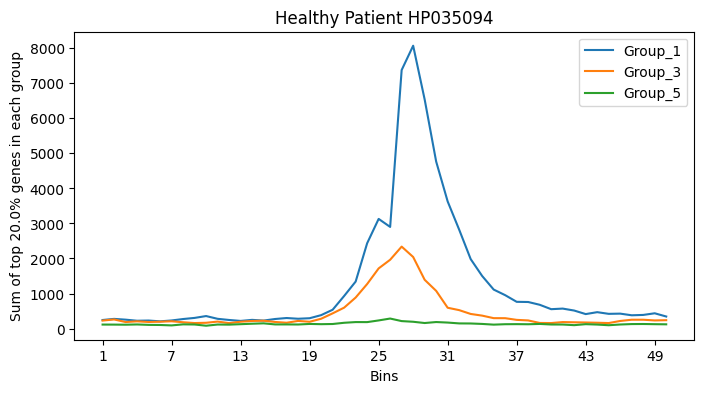

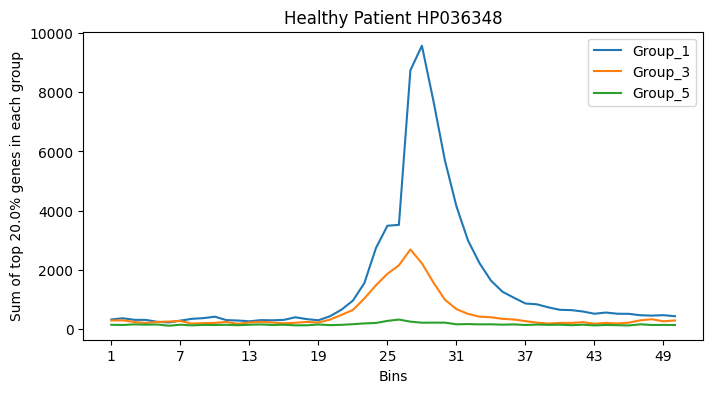

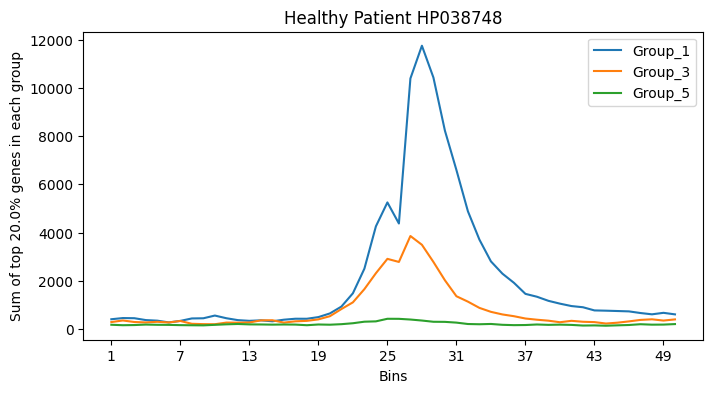

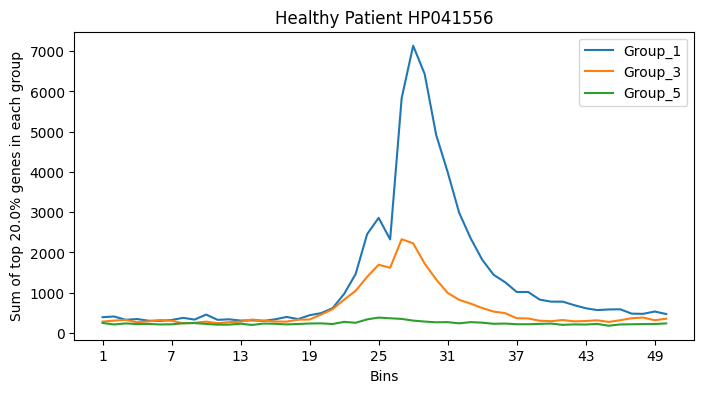

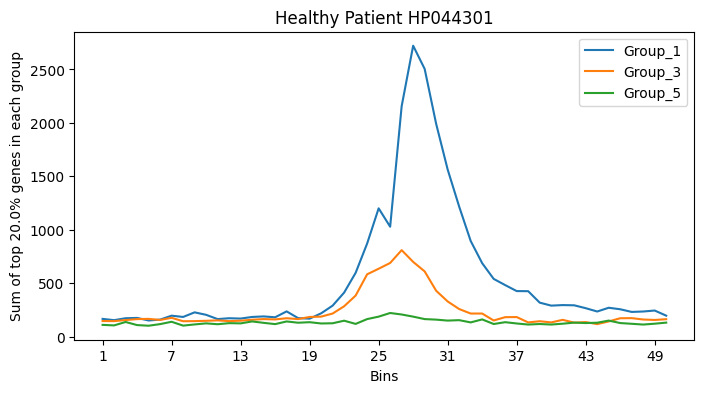

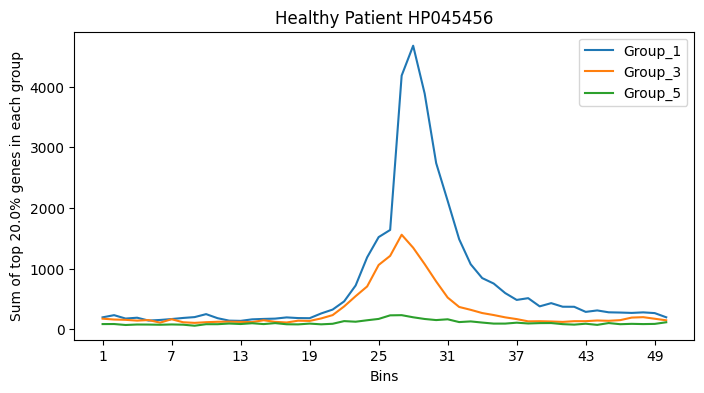

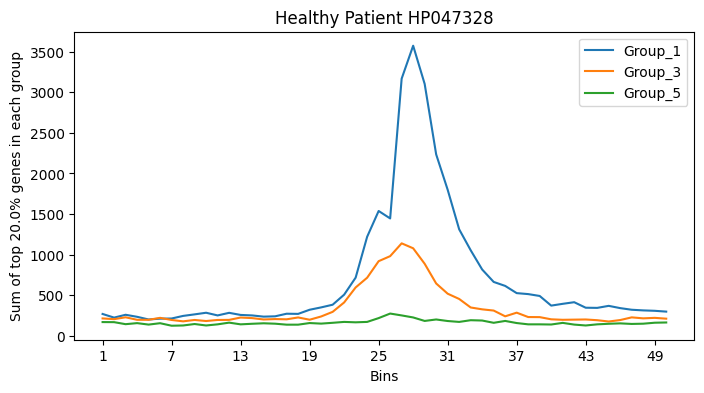

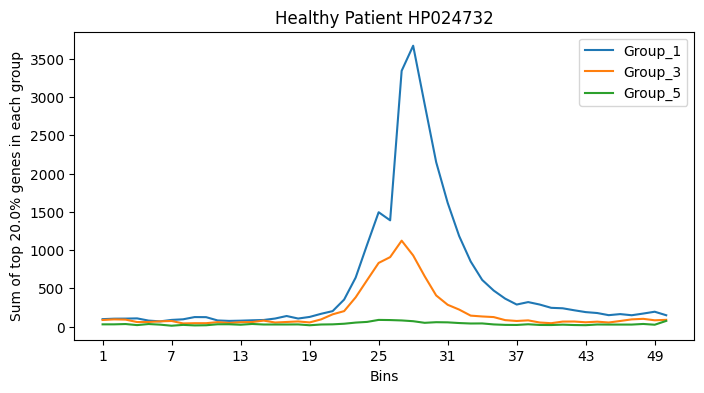

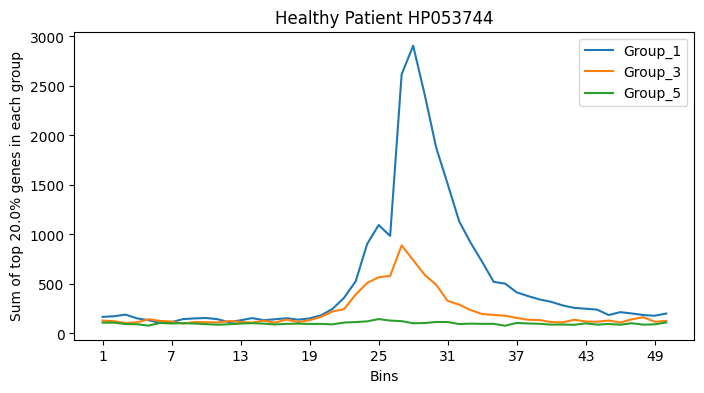

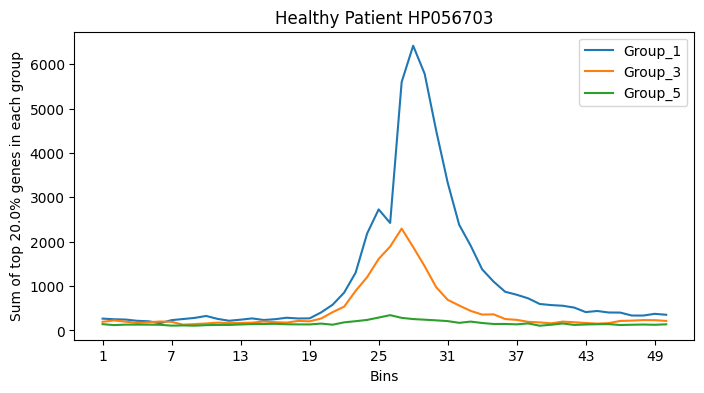

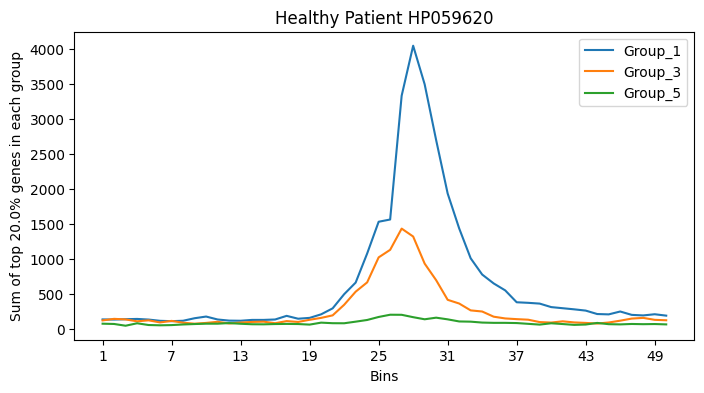

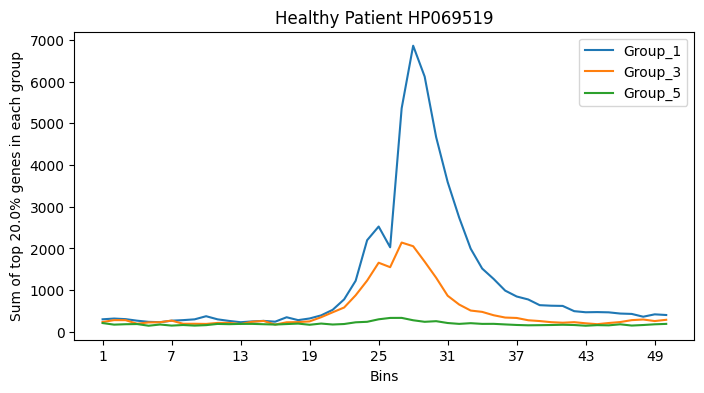

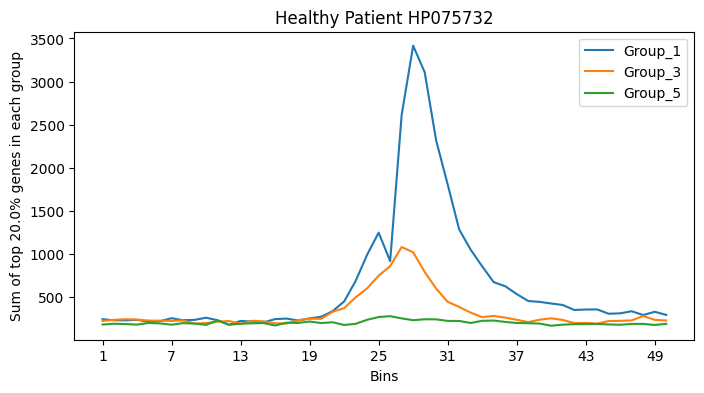

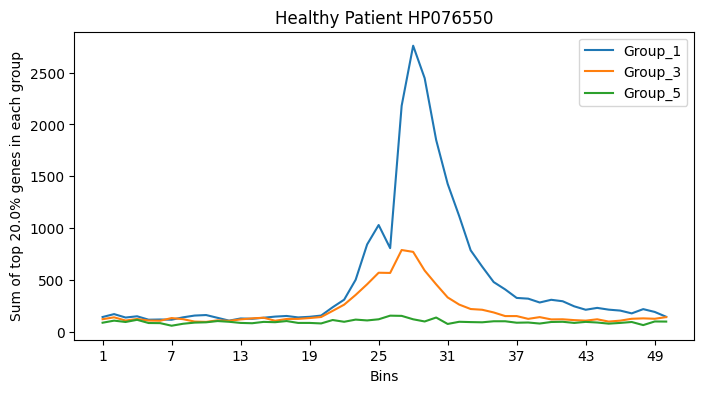

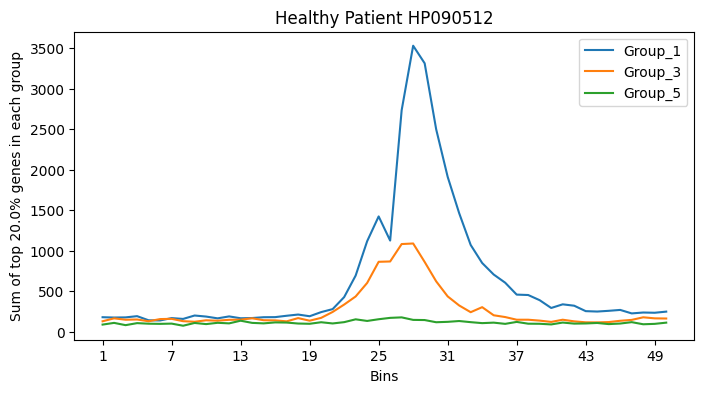

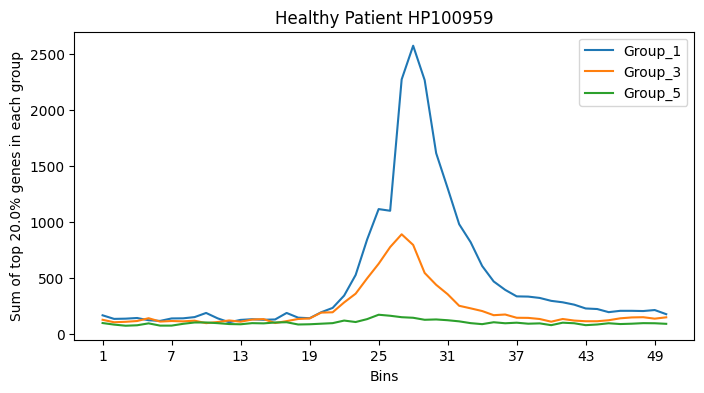

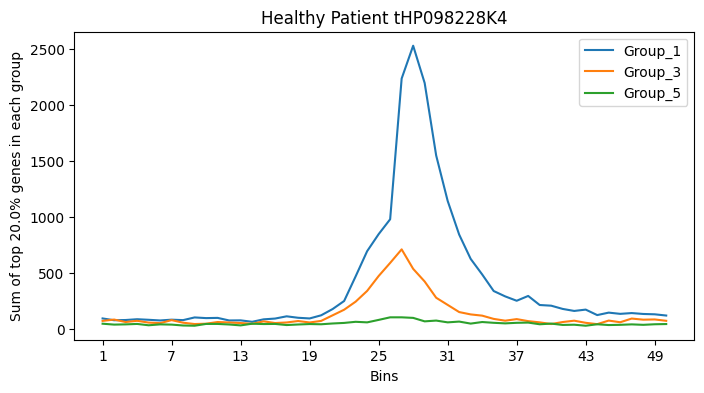

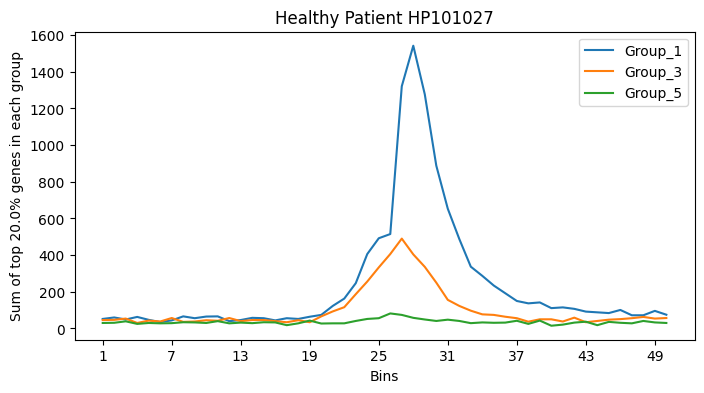

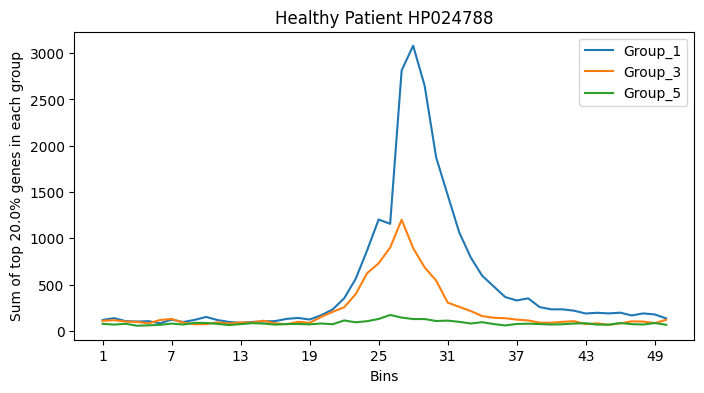

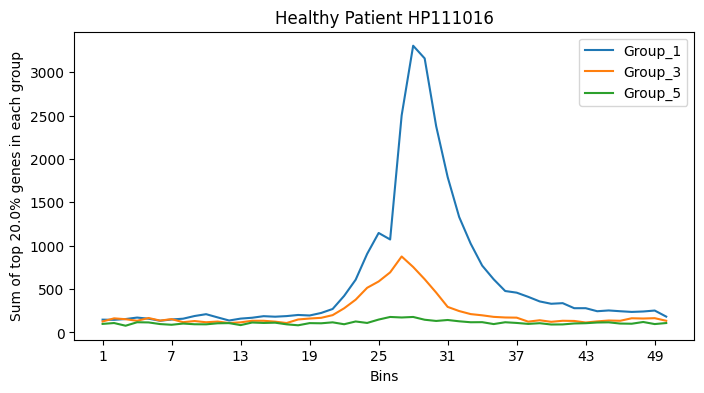

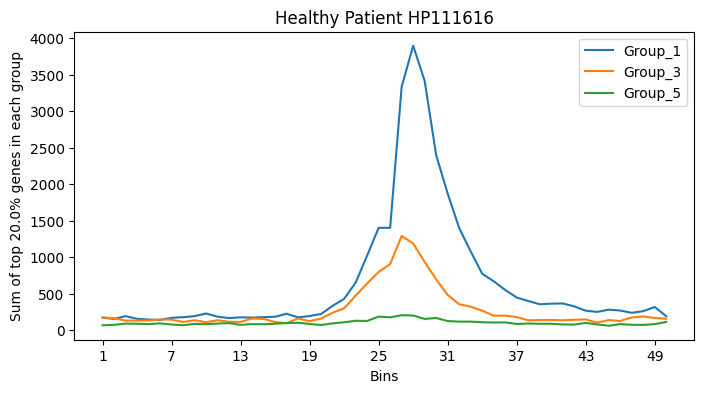

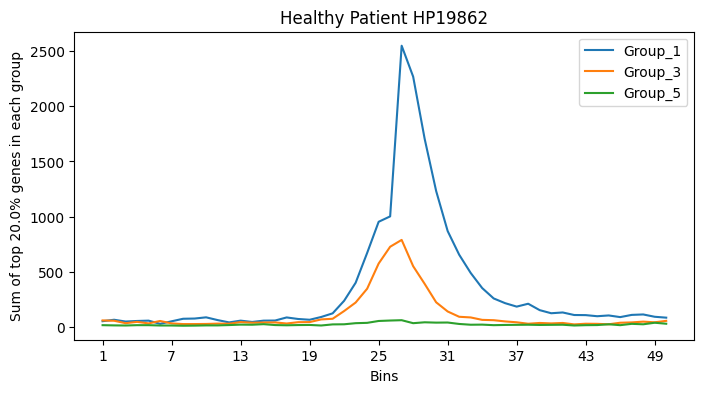

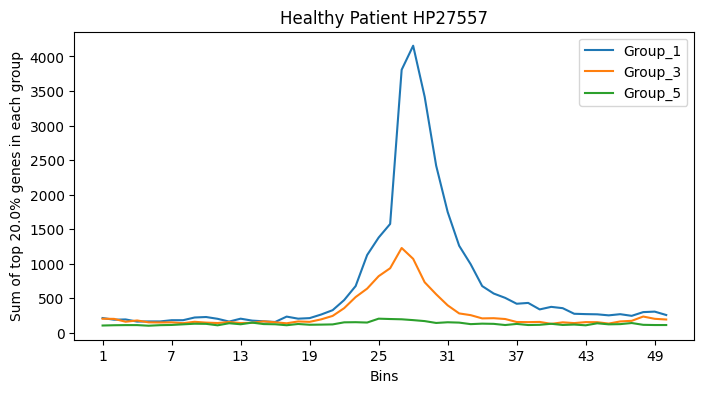

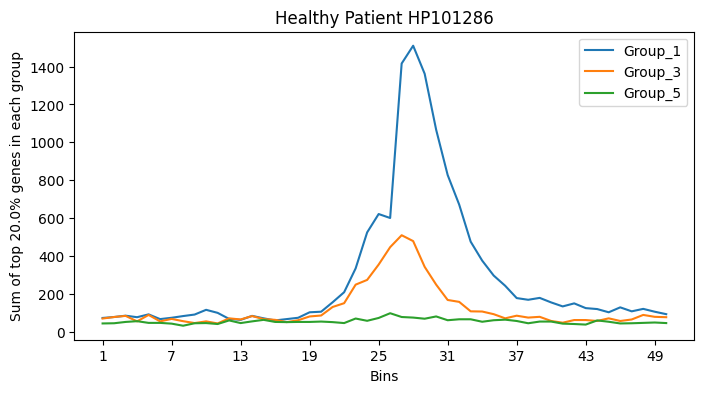

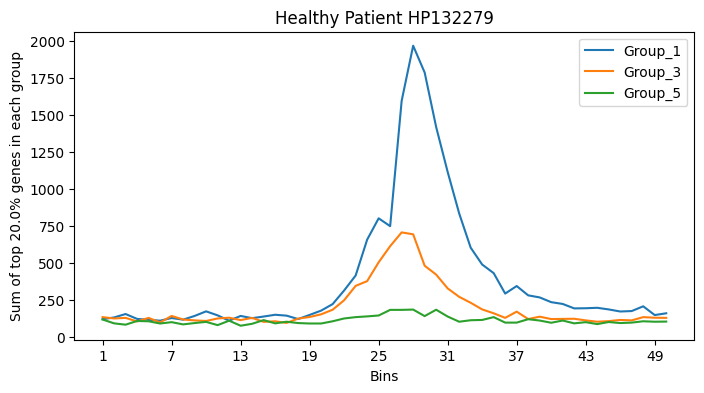

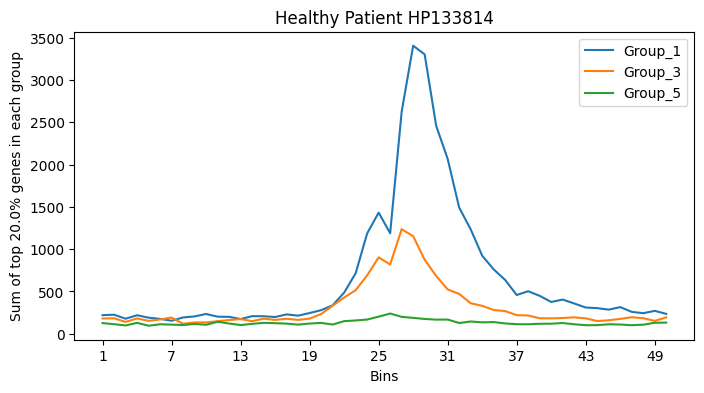

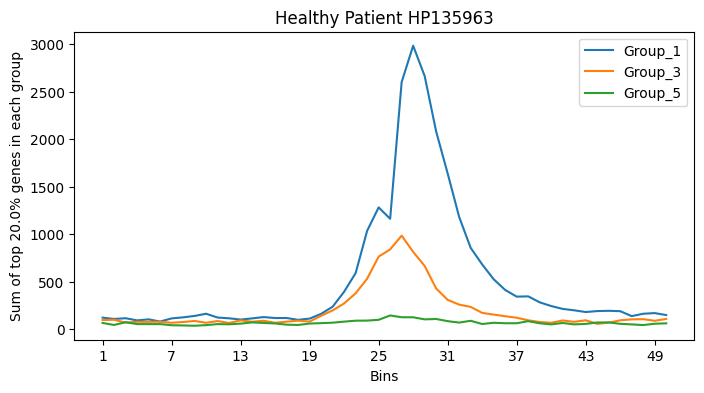

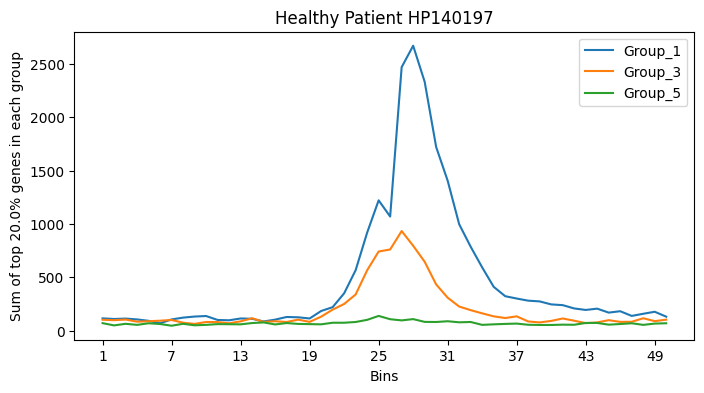

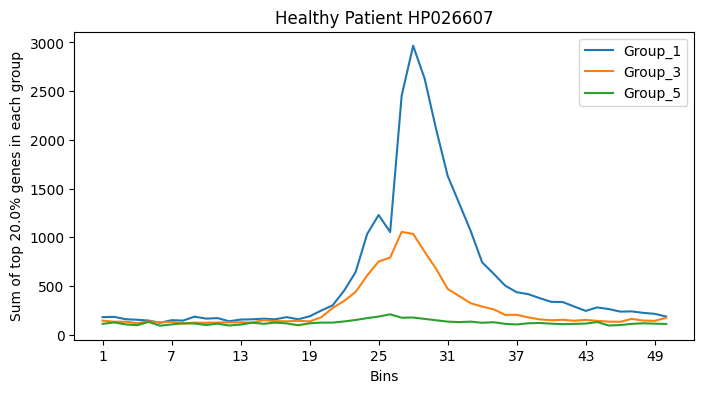

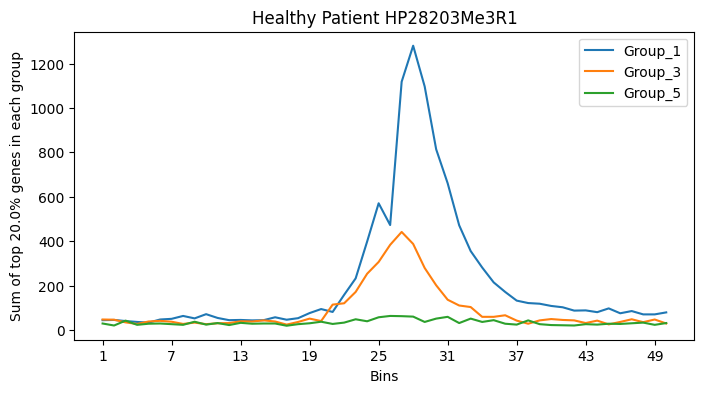

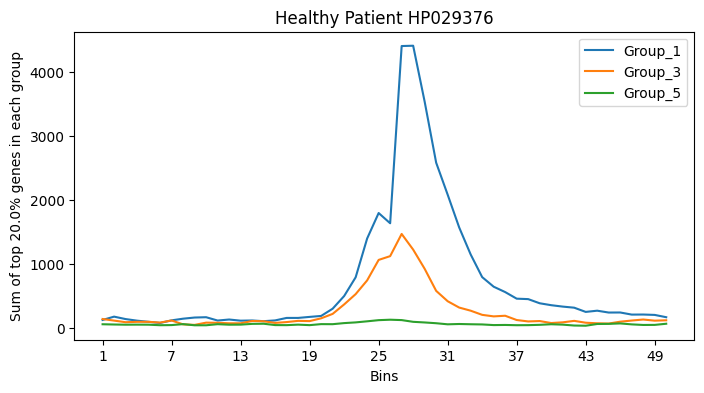

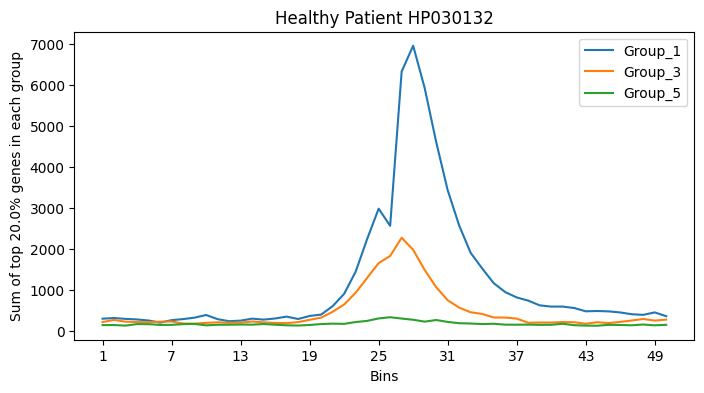

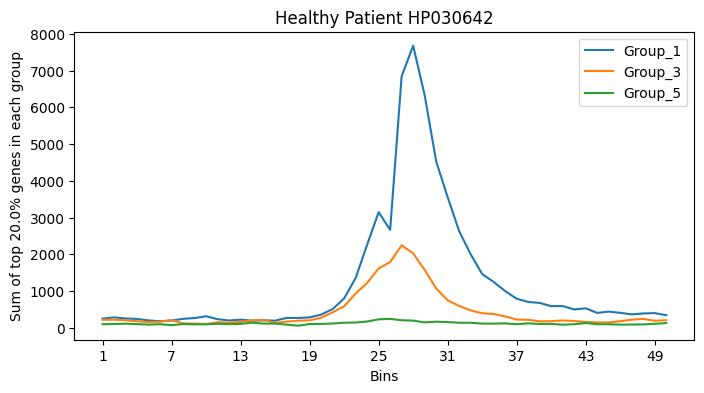

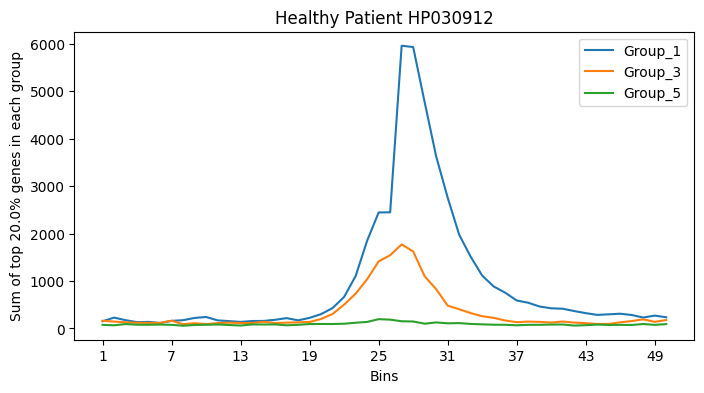

In [11]:
Columns_plot = "FSE_"   # FSE_   FC_
Selected_G = ['Group_1','Group_3','Group_5']
Top_percent_ach_group = 0.2  # get 0.2 from top of each group datfarme with lowest sd   /(Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid].filter(regex='^'+ Columns_plot , axis=1).sum().sum())
Healthy_samples_Qids = list(QID_Dic.keys())


for i_qid, qid in enumerate(Healthy_samples_Qids):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i_g, g in enumerate(Selected_G):

        Genes_in_this_Group = list(Groups_DF_Dic[g].Gene_name)
        Genes_in_this_Group = Genes_in_this_Group[:int(Top_percent_ach_group*len(Genes_in_this_Group))]

        Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[Selected_patient_feature_Df_Group_i_Genes['Gene_name'].isin(Genes_in_this_Group) ]
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

        # select cols
        flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]


        ax.plot(list(Selected_patient_feature_Df_Group_i_Genes[flc_columns].sum()), label=f'{g}')

    # Add labels, legend, and title
    ax.set_xticks(np.arange(0, len(flc_columns), 6))
    ax.set_xticklabels(range(1, len(flc_columns) + 1, 6))

    ax.set_xlabel('Bins')
    ax.set_ylabel(f'Sum of top {Top_percent_ach_group*100}% genes in each group')
    ax.legend()
    ax.set_title(f'{QID_Dic[qid][1]} Patient {QID_Dic[qid][0]}')

    # Show the plot
    plt.show()

# **All patient - FC per bins**

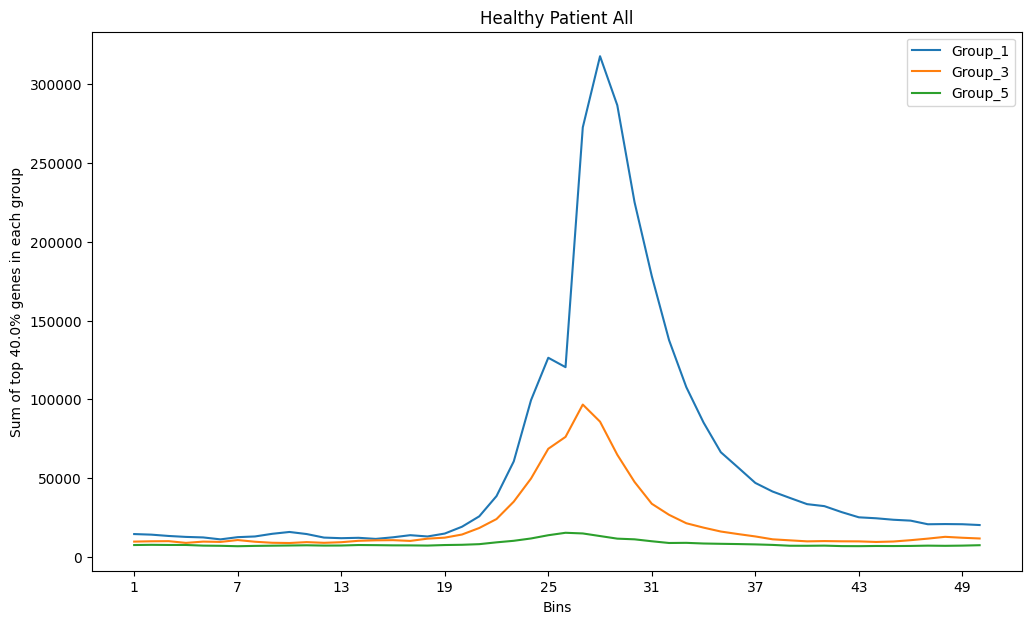

In [12]:
Columns_plot = "FSE_"   # FSE_   FC_
Selected_G = ['Group_1','Group_3','Group_5']
Top_percent_ach_group = 0.4  # get 0.2 from top of each group datfarme with lowest sd
Healthy_samples_Qids = list(QID_Dic.keys())



fig, ax = plt.subplots(figsize=(12, 7))
for i_g, g in enumerate(Selected_G):

    for i_qid, qid in enumerate(Healthy_samples_Qids):
        Genes_in_this_Group = list(Groups_DF_Dic[g].Gene_name)
        Genes_in_this_Group = Genes_in_this_Group[:int(Top_percent_ach_group*len(Genes_in_this_Group))]

        Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[Selected_patient_feature_Df_Group_i_Genes['Gene_name'].isin(Genes_in_this_Group) ]
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

        # select cols
        flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
        if i_qid == 0:
            G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns].sum()) )
        else:
            G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns].sum()) )

    ax.plot(G_np_list, label=f'{g}')

# Add labels, legend, and title
ax.set_xticks(np.arange(0, len(G_np_list), 6))
ax.set_xticklabels(range(1, len(G_np_list) + 1, 6))

ax.set_xlabel('Bins')
ax.set_ylabel(f'Sum of top {Top_percent_ach_group*100}% genes in each group')
ax.legend()
ax.set_title(f'{QID_Dic[qid][1]} Patient All')

# Show the plot
plt.show()

# **Relationship between H3K4me3 and Gene Expression**

In [13]:
import gzip

file_path = OP["Drive_Dir"]+'Data/'+ 'GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'

# Read the gzipped GCT file into a DataFrame
with gzip.open(file_path, 'rt') as f:
    GTEx_df = pd.read_csv(f, sep='\t', skiprows=2, index_col=0)

GTEx_df.rename(columns={'Description': 'Gene_name', 'Whole Blood': 'Label_GTex_TPM'}, inplace=True)
GTEx_df = GTEx_df[['Gene_name','Label_GTex_TPM']].reset_index(drop=True)
GTEx_df.head()

Gene_name  Label_GTex_TPM
0     DDX11L1         0.11750
1      WASH7P         8.43900
2  MIR1302-11         0.00000
3     FAM138A         0.02574
4      OR4G4P         0.00000

## Every Group --- Scatter Plot H3K4me3 features VS Gene Expression

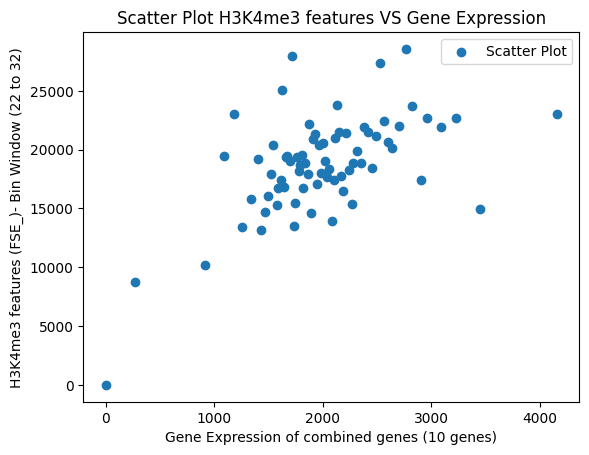

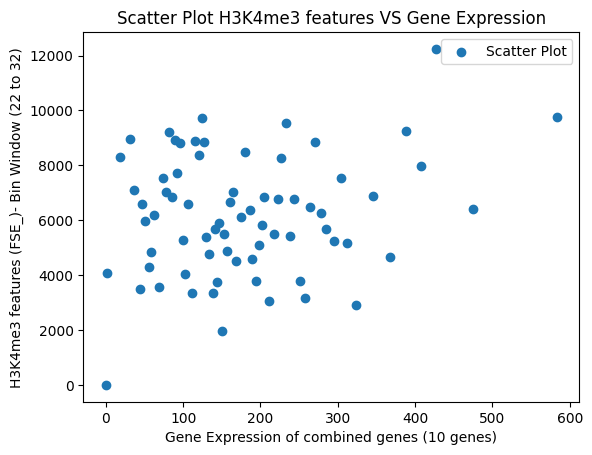

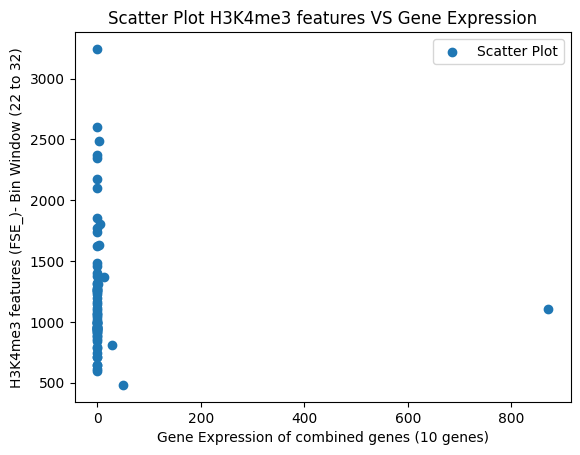

In [14]:


Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FSE_"   # FSE_   FC_
Selected_G = ['Group_1','Group_3','Group_5']
Top_percent_ach_group = 0.3  # get 0.2 from top of each group datfarme with lowest sd
Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 22
Bins_ave_e = 32

for i_g, g in enumerate(Selected_G):

    for i_qid, qid in enumerate(Healthy_samples_Qids):
        Genes_in_this_Group = list(Groups_DF_Dic[g].Gene_name)
        Genes_in_this_Group = Genes_in_this_Group[:int(Top_percent_ach_group*len(Genes_in_this_Group))]

        Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
        if Flag_typeGE == 'TPM':
            Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
            Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[Selected_patient_feature_Df_Group_i_Genes['Gene_name'].isin(Genes_in_this_Group) ]
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)

        # select cols
        flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
        Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
        if i_qid == 0:
            G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
            label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

        else:
            G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
            label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    x_val = []
    y_val = []
    for i in range(0, len(G_np_list), every_N):
      y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
      x_val.append(np.sum(label_np_list[i:i+every_N]))
    plt.scatter(x_val, y_val, label='Scatter Plot')
    # Add labels and title
    plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
    plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
    plt.title('Scatter Plot H3K4me3 features VS Gene Expression')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


## All FSE --- Scatter Plot H3K4me3 features VS Gene Expression

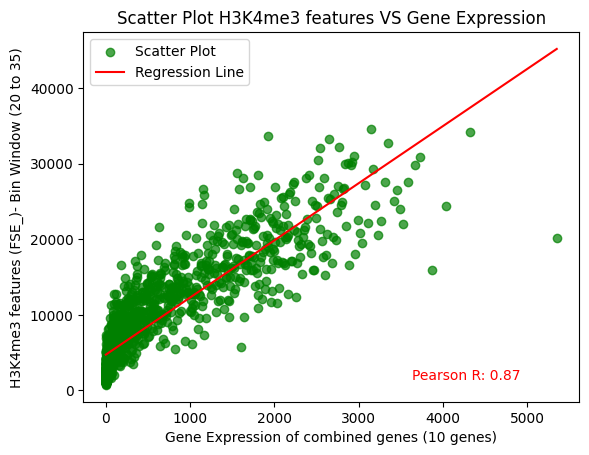

In [15]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FSE_"   # FSE_   FC_

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='green', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)
corr_text = f'Pearson R: {corr_coeff:.2f}'
plt.annotate(corr_text, xy=(round(max(X)[0]*0.8), round(max(y)*0.2)), xytext=(0, -30), ha='center', textcoords='offset points', color='red')

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title('Scatter Plot H3K4me3 features VS Gene Expression')

# Add legend
plt.legend()

# Show the plot
plt.show()



## All FC --- Scatter Plot H3K4me3 features VS Gene Expression

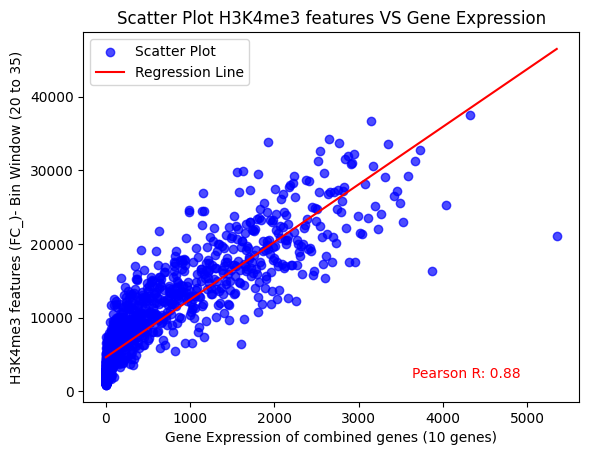

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FC_"   # FSE_   FC_

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='blue', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)
corr_text = f'Pearson R: {corr_coeff:.2f}'
plt.annotate(corr_text, xy=(round(max(X)[0]*0.8), round(max(y)*0.2)), xytext=(0, -30), ha='center', textcoords='offset points', color='red')

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title('Scatter Plot H3K4me3 features VS Gene Expression')

# Add legend
plt.legend()

# Show the plot
plt.show()



## All FL_median_ - Many MISSING VALUES --- Scatter Plot H3K4me3 features VS Gene Expression

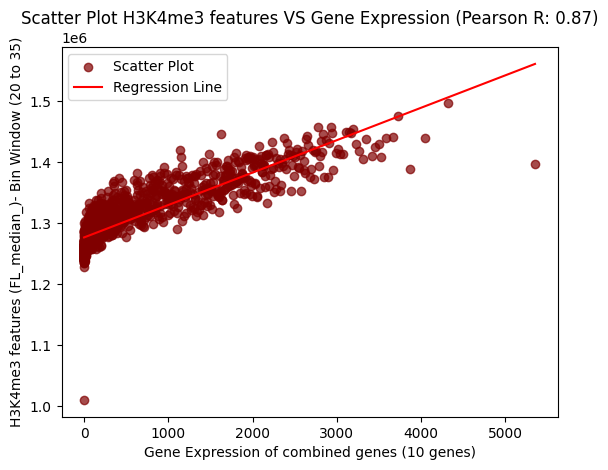

In [17]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FL_median_"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='maroon', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title(f'Scatter Plot H3K4me3 features VS Gene Expression (Pearson R: {corr_coeff:.2f})')

# Add legend
plt.legend()

# Show the plot
plt.show()



## All GC_Small --- Scatter Plot H3K4me3 features VS Gene Expression

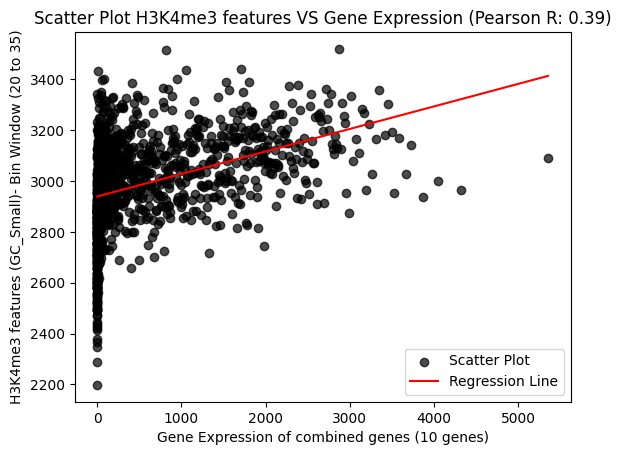

In [18]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "GC_Small"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='black', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title(f'Scatter Plot H3K4me3 features VS Gene Expression (Pearson R: {corr_coeff:.2f})')

# Add legend
plt.legend()

# Show the plot
plt.show()



## All GC_Skew_Small --- Scatter Plot H3K4me3 features VS Gene Expression

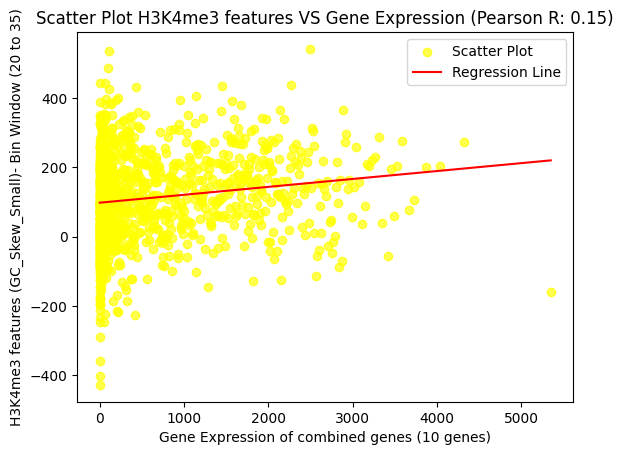

In [19]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "GC_Skew_Small"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='yellow', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title(f'Scatter Plot H3K4me3 features VS Gene Expression (Pearson R: {corr_coeff:.2f})')

# Add legend
plt.legend()

# Show the plot
plt.show()



## All AT_Skew_Small --- Scatter Plot H3K4me3 features VS Gene Expression

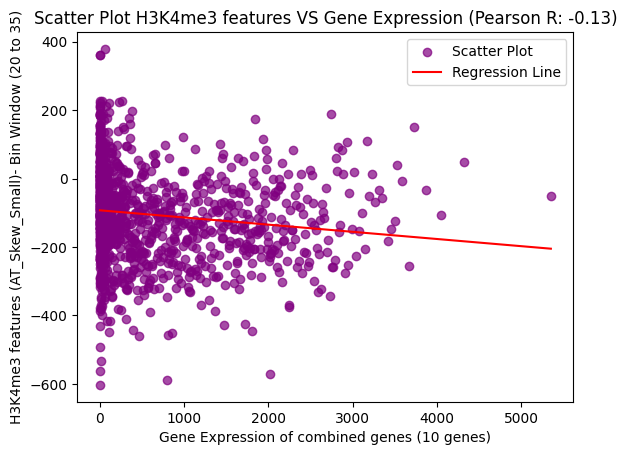

In [20]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "AT_Skew_Small"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )


x_val = []
y_val = []
for i in range(0, len(G_np_list), every_N):
  y_val.append(np.sum(sum(G_np_list[i:i+every_N])[Bins_ave_s:Bins_ave_e]))
  x_val.append(np.sum(label_np_list[i:i+every_N]))


plt.scatter(x_val, y_val, label='Scatter Plot', color='purple', alpha=0.7)

# Linear regression
X = np.array(x_val).reshape(-1, 1)
y = np.array(y_val)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Calculate and add the correlation coefficient
corr_coeff, _ = pearsonr(x_val, y_val)

# Add labels and title
plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
plt.ylabel(f'H3K4me3 features ({Columns_plot})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
plt.title(f'Scatter Plot H3K4me3 features VS Gene Expression (Pearson R: {corr_coeff:.2f})')

# Add legend
plt.legend()

# Show the plot887iujm k
plt.show()

## All FLC_P --- Scatter Plot H3K4me3 features VS Gene Expression

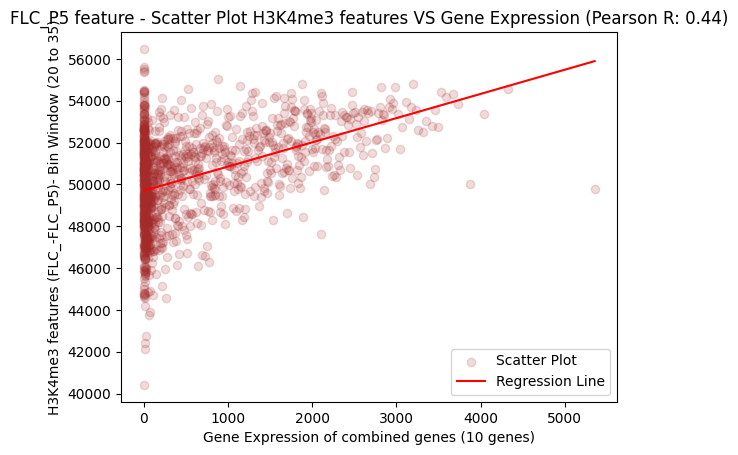

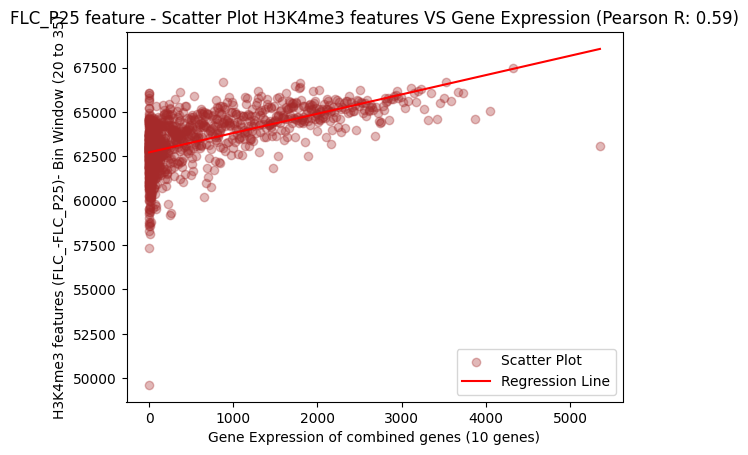

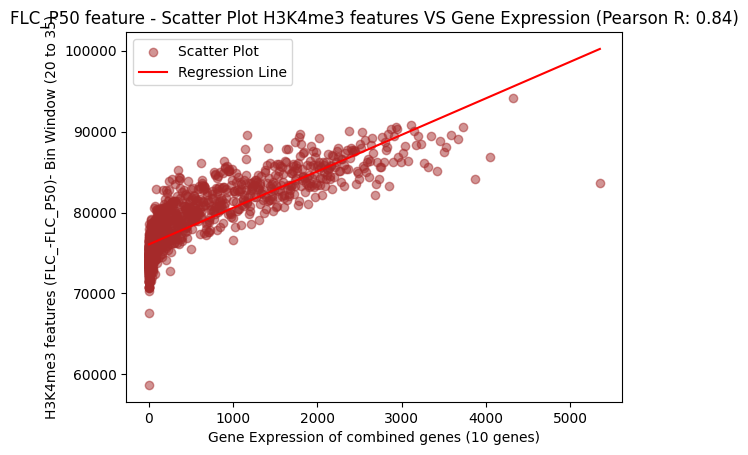

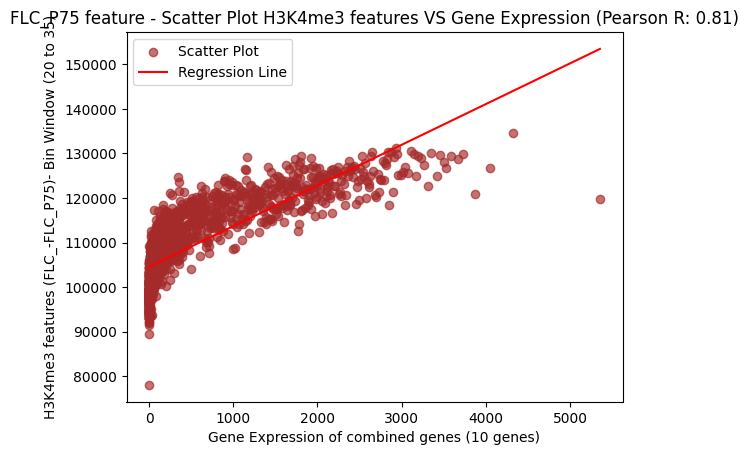

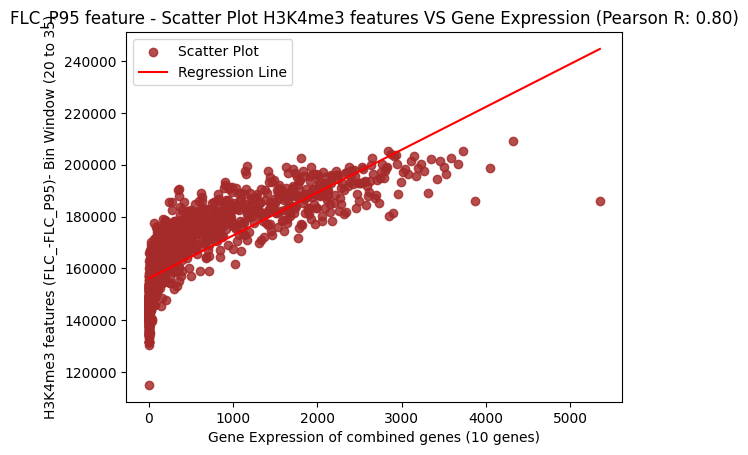

In [21]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FLC_"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10
Bins_ave_s = 20
Bins_ave_e = 35


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )





for pl_i, pl in enumerate([i for i in list(Selected_patient_feature_Df_Group_i_Genes.columns) if i not in{'Gene_name','Label'}]):
      x_val = []
      y_val = []
      for i in range(0, len(G_np_list), every_N):
        y_val.append(np.sum(sum(G_np_list[i:i+every_N])[pl_i]))
        x_val.append(np.sum(label_np_list[i:i+every_N]))


      plt.scatter(x_val, y_val, label='Scatter Plot', color='brown', alpha=((pl_i+1)/6))

      # Linear regression
      X = np.array(x_val).reshape(-1, 1)
      y = np.array(y_val)
      model = LinearRegression().fit(X, y)
      y_pred = model.predict(X)

      # Plot the regression line
      plt.plot(X, y_pred, color='red', label='Regression Line')

      # Calculate and add the correlation coefficient
      corr_coeff, _ = pearsonr(x_val, y_val)

      # Add labels and title
      plt.xlabel(f'Gene Expression of combined genes ({every_N} genes)')
      plt.ylabel(f'H3K4me3 features ({Columns_plot}-{pl})- Bin Window ({Bins_ave_s} to {Bins_ave_e})')
      plt.title(f'{pl} feature - Scatter Plot H3K4me3 features VS Gene Expression (Pearson R: {corr_coeff:.2f})')

      # Add legend
      plt.legend()

      # Show the plot
      plt.show()




# **Histogram of fragments lengths - shifting hight to low GE**

In [22]:
Flag_typeGE = 'TPM'   # TPM FPKM

Columns_plot = "FL_Width_List_Small"   # "FL_median_", "GC_Small","FLC_", "GC_Skew_Small", "AT_Skew_Small","FSE_Small"

Healthy_samples_Qids = list(QID_Dic.keys())
every_N = 10


for i_qid, qid in enumerate(Healthy_samples_Qids):
    Selected_patient_feature_Df_Group_i_Genes = Raw_ALL_Data[Raw_ALL_Data['Qid'] == qid]
    if Flag_typeGE == 'TPM':
        Selected_patient_feature_Df_Group_i_Genes = pd.merge(Selected_patient_feature_Df_Group_i_Genes, GTEx_df, on='Gene_name').drop(columns = ['Label'])
        Selected_patient_feature_Df_Group_i_Genes.rename(columns={'Label_GTex_TPM': 'Label'}, inplace=True)
        Selected_patient_feature_Df_Group_i_Genes['Label'] = np.log2(Selected_patient_feature_Df_Group_i_Genes['Label'] + 1)
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes.sort_values(by =['Label'], ascending=False).reset_index(drop=True)

    # select cols
    flc_columns = list(Selected_patient_feature_Df_Group_i_Genes.filter(regex='^'+ Columns_plot , axis=1))
    Selected_patient_feature_Df_Group_i_Genes = Selected_patient_feature_Df_Group_i_Genes[['Gene_name','Label'] + flc_columns]
    for CCC in [col for col in Data_raw.columns if any(col.startswith(prefix) for prefix in ['FL_Width_List_Small'])]:
          Selected_patient_feature_Df_Group_i_Genes[CCC] = Selected_patient_feature_Df_Group_i_Genes[CCC].apply(lambda x: (x,) if not isinstance(x, tuple) else x)

    if i_qid == 0:
        G_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

    else:
        G_np_list = G_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes[flc_columns]) )
        label_np_list = label_np_list + np.array((Selected_patient_feature_Df_Group_i_Genes['Label']) )

DF_G_np_list = pd.DataFrame(G_np_list,columns=flc_columns)
DF_G_np_list.insert(0, 'Gene_name', list(Selected_patient_feature_Df_Group_i_Genes['Gene_name']))



<ipython-input-22-423a507eb06e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_patient_feature_Df_Group_i_Genes[CCC] = Selected_patient_feature_Df_Group_i_Genes[CCC].apply(lambda x: (x,) if not isinstance(x, tuple) else x)
<ipython-input-22-423a507eb06e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_patient_feature_Df_Group_i_Genes[CCC] = Selected_patient_feature_Df_Group_i_Genes[CCC].apply(lambda x: (x,) if not isinstance(x, tuple) else x)


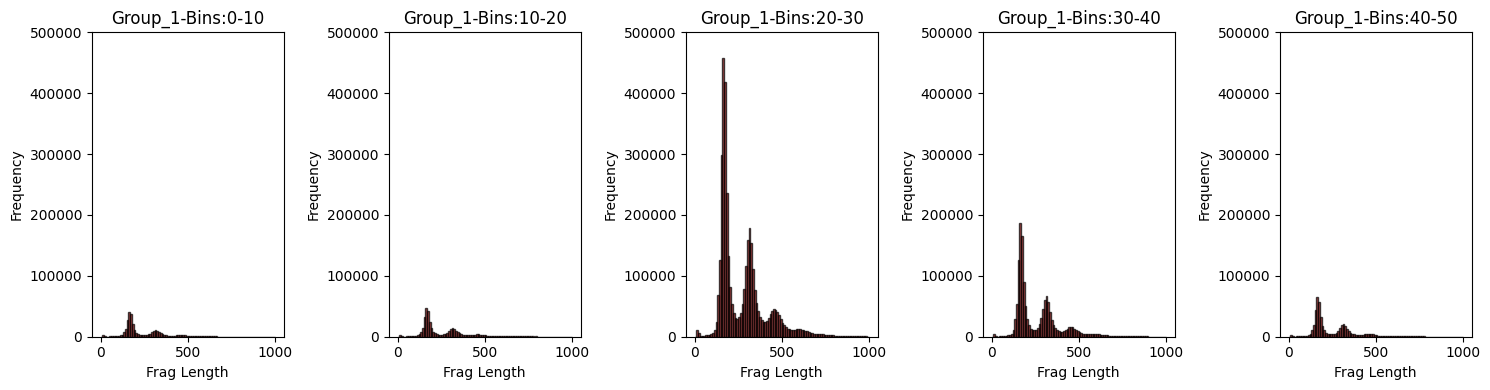

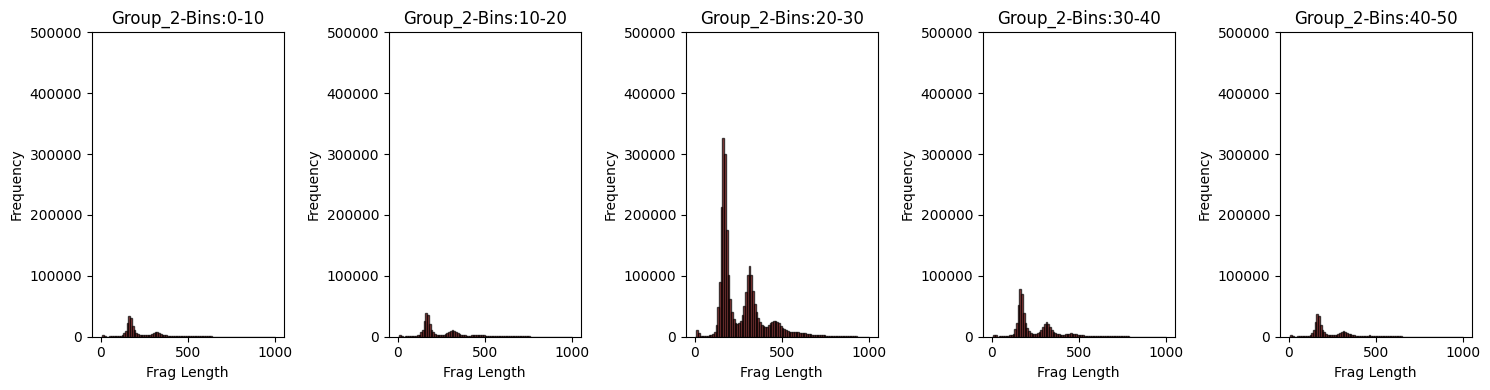

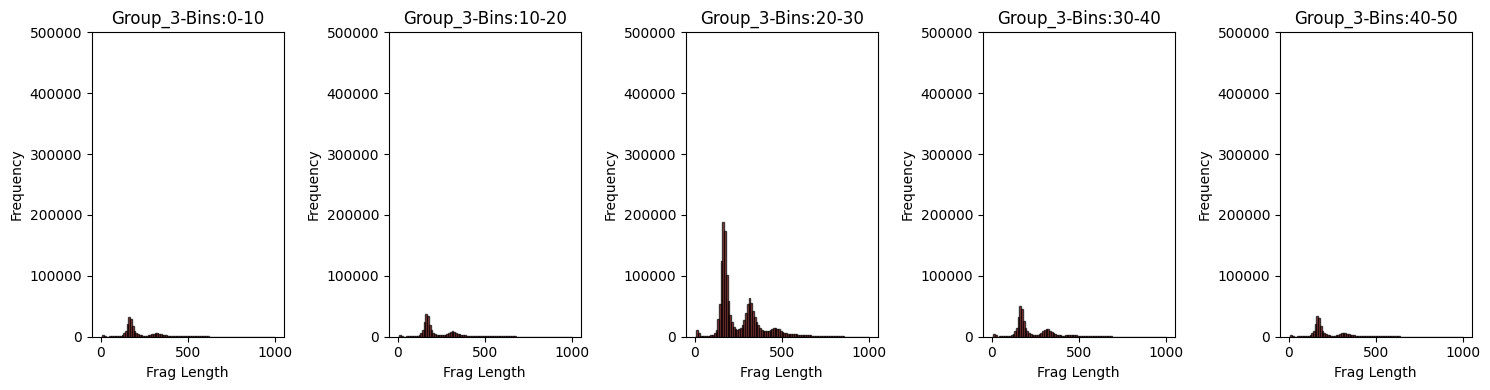

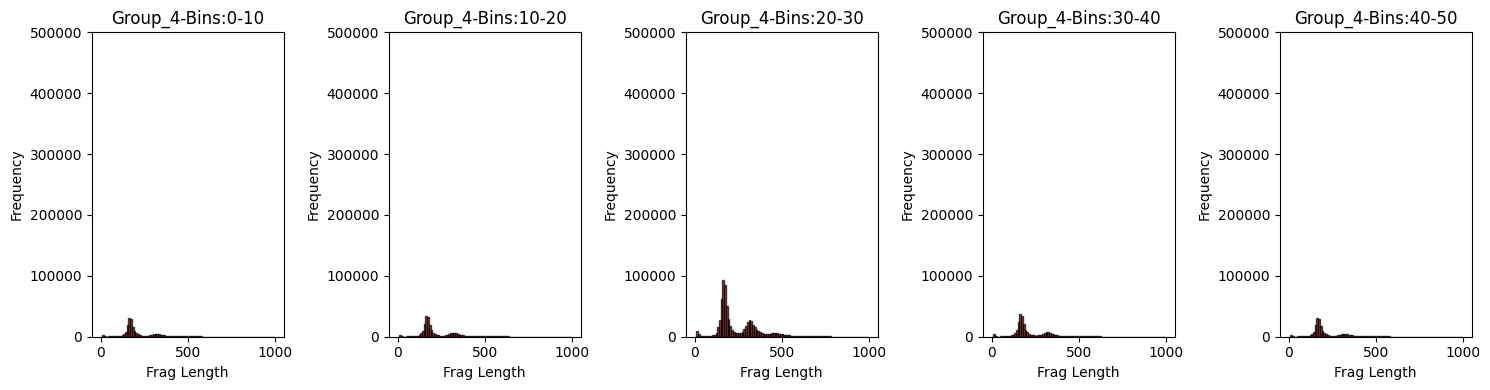

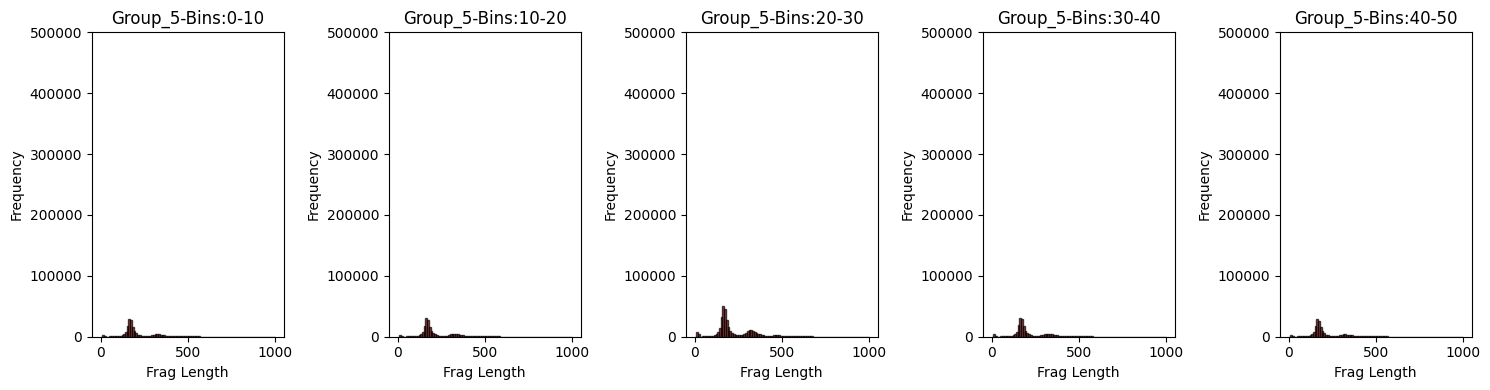

In [23]:
for i_g, g in enumerate(Groups_DF_Dic.keys()):
        Genes_in_this_Group = list(Groups_DF_Dic[g].Gene_name)
        AA = DF_G_np_list[DF_G_np_list['Gene_name'].isin(Genes_in_this_Group) ]
        AA = (AA.drop(columns=['Gene_name']).sum())  # sum all genes tuples - AA has 50 columns corresponding to 50 bins

        # Create subplots
        fig, axs = plt.subplots(1, int(50/every_N), figsize=(15, 4))
        # Iterate through S_E_list
        for i, IJ in enumerate(range(0, 50, every_N)):
            # Filter and calculate the tuple
            filtered_tuple = tuple(value for value in AA[IJ:IJ+every_N].sum() if value != 0)  # sum all tuples of bins IJ:IJ+every_N and remove zeros

            # Plot on the corresponding subplot
            axs[i].hist(filtered_tuple, bins=range(0, 1001, 10), edgecolor='black',color='maroon', alpha=0.7)

            # Adding labels and title for each subplot
            axs[i].set_xlabel('Frag Length')
            axs[i].set_ylabel('Frequency')
            axs[i].set_title(f'{g}-Bins:{IJ}-{IJ+every_N}')
            # Set y-axis limits
            axs[i].set_ylim([0, 500000])  # Adjust the upper limit as needed

        # Adjus

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()



array([3, 6, 9])

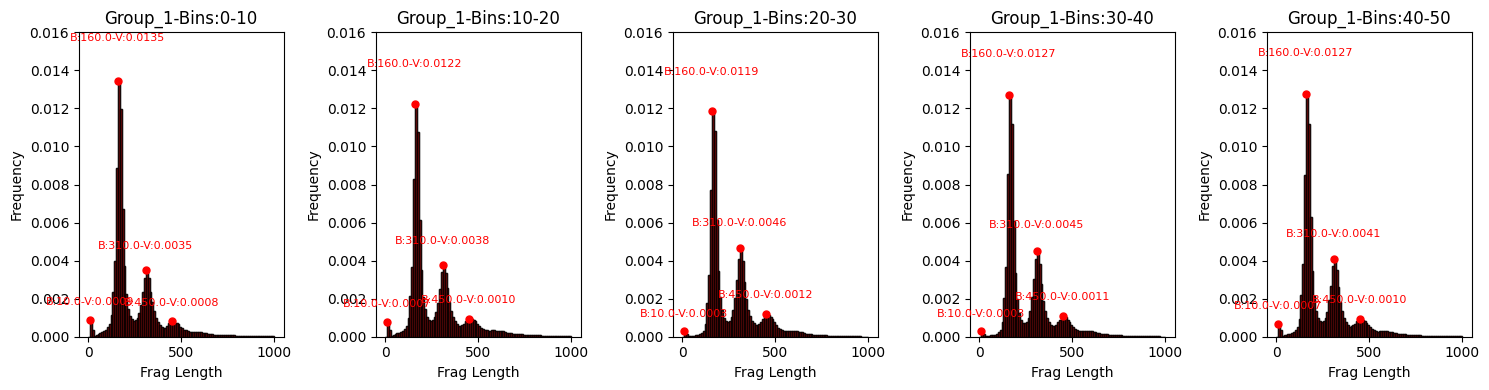

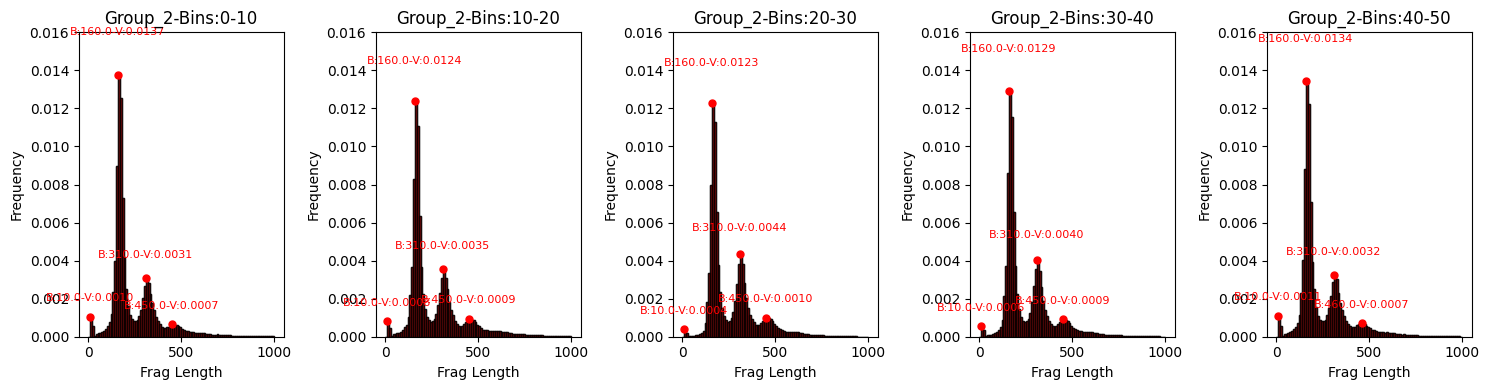

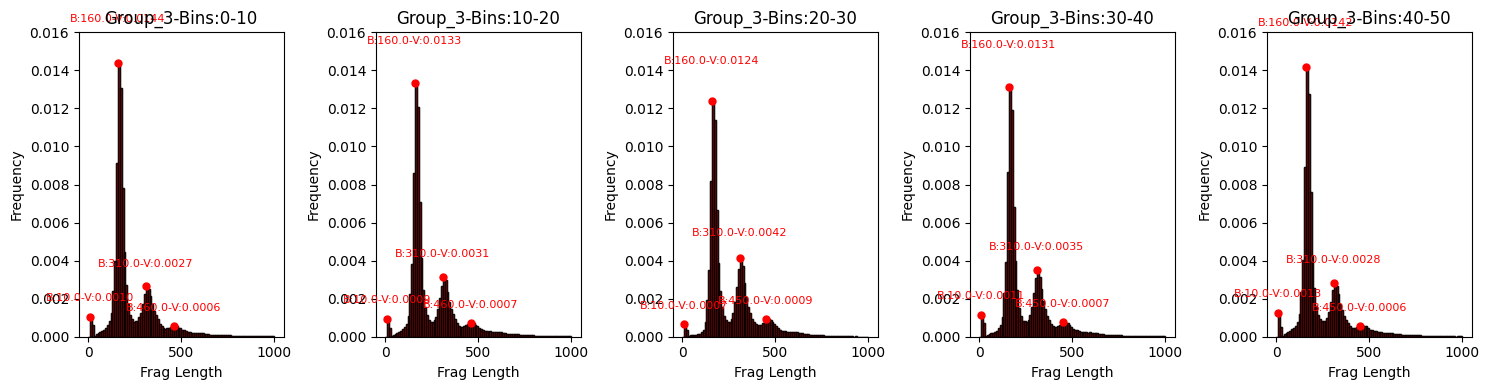

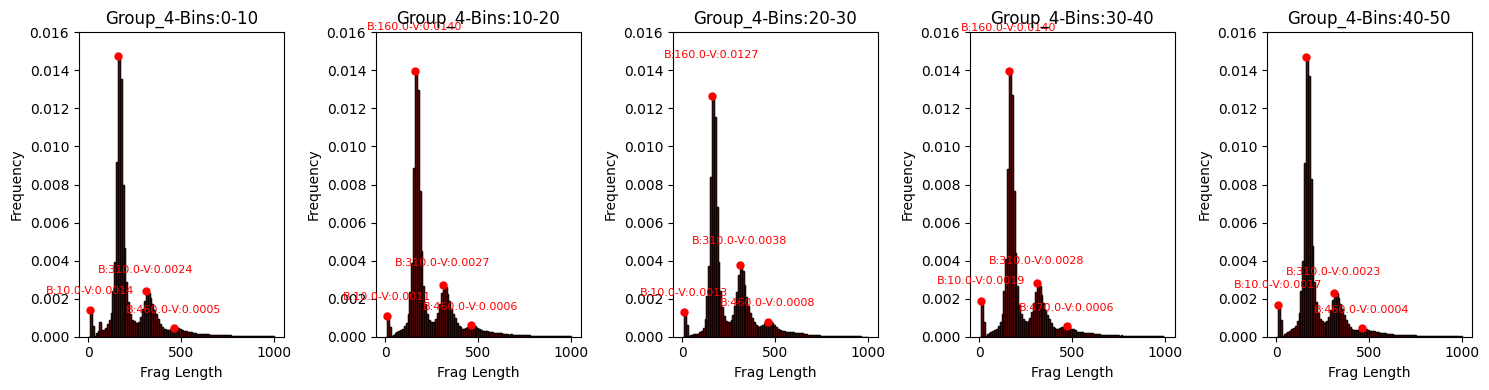

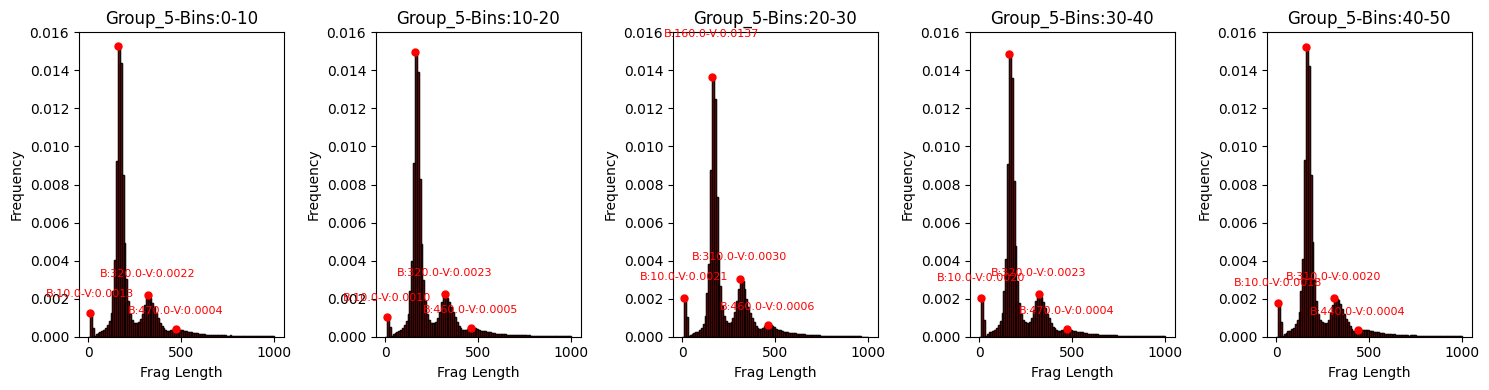

In [94]:

Histogram_bin_width = 10

from scipy.signal import find_peaks
PeakDiff_Dic = {f'Bins:{IJ}-{IJ+every_N}':{'groups':[],'Peak_2_Minus_1':[],'Peak_2_Minus_3':[],'Peak_2_Minus_4':[],'Peak_3_Minus_4':[],'Peak_1_OVER_2':[], 'Peak_3_OVER_2':[], 'Peak_4_OVER_3':[]} for i, IJ in enumerate(range(0, 50, every_N))}

for i_g, g in enumerate(Groups_DF_Dic.keys()):
        Genes_in_this_Group = list(Groups_DF_Dic[g].Gene_name)
        AA = DF_G_np_list[DF_G_np_list['Gene_name'].isin(Genes_in_this_Group) ]
        AA = (AA.drop(columns=['Gene_name']).sum())  # sum all genes tuples - AA has 50 columns corresponding to 50 bins

        # Create subplots
        fig, axs = plt.subplots(1, int(50/every_N), figsize=(15, 4))
        # Iterate through S_E_list
        for i, IJ in enumerate(range(0, 50, every_N)):
            # Filter and calculate the tuple
            filtered_tuple = tuple(value for value in AA[IJ:IJ+every_N].sum() if value != 0)  # sum all tuples of bins IJ:IJ+every_N and remove zeros

            # Plot on the corresponding subplot
            axs[i].hist(filtered_tuple, bins=range(0, 1001, 10), edgecolor='black',color='maroon', alpha=0.7, density =True)
            # Find peaks in the histogram
            hist, bins, _ = axs[i].hist(filtered_tuple, bins=range(0, 1001, Histogram_bin_width), edgecolor='black',color='maroon', alpha=0.7, density =True)
            peaks, _ = find_peaks(hist)
            peak_values = hist[peaks]
            if g == 'Group_4' and IJ == 0:
                peak_values = np.delete(peak_values, 1)
                peaks = np.delete(peaks, 1)
            axs[i].plot(bins[peaks[:4]], peak_values[:4], ".", color="red", markersize=10)
            for a in [0,1,2,3]:
                axs[i].annotate(f'B:{bins[peaks[a]]}-V:{peak_values[a]:0.4f}', (bins[peaks[a]], 1.1*peak_values[a]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='red')
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['groups'].append(g)
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_2_Minus_1'].append(peak_values[1] - peak_values[0])
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_2_Minus_3'].append(peak_values[1] - peak_values[2])
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_2_Minus_4'].append(peak_values[1] - peak_values[3])
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_3_Minus_4'].append(peak_values[2] - peak_values[3])

            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_1_OVER_2'].append(peak_values[0]/peak_values[1])
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_3_OVER_2'].append(peak_values[2]/peak_values[1])
            PeakDiff_Dic[f'Bins:{IJ}-{IJ+every_N}']['Peak_4_OVER_3'].append(peak_values[3]/peak_values[2])

            # Adding labels and title for each subplot
            axs[i].set_xlabel('Frag Length')
            axs[i].set_ylabel('Frequency')
            axs[i].set_title(f'{g}-Bins:{IJ}-{IJ+every_N}')
            # Set y-axis limits
            axs[i].set_ylim([0, 0.016])  # Adjust the upper limit as needed

        # Adjus

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()



In [95]:
for KK in PeakDiff_Dic:
  print('Peak Diff for ',KK)
  display(pd.DataFrame(PeakDiff_Dic[KK]))

Peak Diff for  Bins:0-10


groups  Peak_2_Minus_1  Peak_2_Minus_3  Peak_2_Minus_4  Peak_3_Minus_4  \
0  Group_1        0.012582        0.009946        0.012634        0.002688   
1  Group_2        0.012716        0.010654        0.013063        0.002408   
2  Group_3        0.013362        0.011725        0.013825        0.002100   
3  Group_4        0.013357        0.012357        0.014280        0.001923   
4  Group_5        0.014046        0.013127        0.014891        0.001765   

   Peak_1_OVER_2  Peak_3_OVER_2  Peak_4_OVER_3  
0       0.064636       0.260627       0.233309  
1       0.074424       0.224504       0.219178  
2       0.071144       0.184901       0.210624  
3       0.093977       0.161798       0.193677  
4       0.081723       0.141845       0.186712

Peak Diff for  Bins:10-20


groups  Peak_2_Minus_1  Peak_2_Minus_3  Peak_2_Minus_4  Peak_3_Minus_4  \
0  Group_1        0.011473        0.008436        0.011270        0.002833   
1  Group_2        0.011574        0.008840        0.011446        0.002607   
2  Group_3        0.012398        0.010196        0.012609        0.002412   
3  Group_4        0.012868        0.011264        0.013365        0.002101   
4  Group_5        0.013898        0.012693        0.014467        0.001775   

   Peak_1_OVER_2  Peak_3_OVER_2  Peak_4_OVER_3  
0       0.061359       0.309782       0.251669  
1       0.064992       0.285924       0.263582  
2       0.069697       0.234911       0.229427  
3       0.079401       0.194140       0.225913  
4       0.070198       0.150818       0.212808

Peak Diff for  Bins:20-30


groups  Peak_2_Minus_1  Peak_2_Minus_3  Peak_2_Minus_4  Peak_3_Minus_4  \
0  Group_1        0.011555        0.007207        0.010673        0.003466   
1  Group_2        0.011848        0.007896        0.011273        0.003377   
2  Group_3        0.011694        0.008218        0.011464        0.003246   
3  Group_4        0.011364        0.008896        0.011865        0.002969   
4  Group_5        0.011603        0.010647        0.013051        0.002405   

   Peak_1_OVER_2  Peak_3_OVER_2  Peak_4_OVER_3  
0       0.024910       0.391836       0.253500  
1       0.034114       0.356270       0.227163  
2       0.055078       0.335943       0.219351  
3       0.102610       0.297453       0.211864  
4       0.150601       0.220579       0.201941

Peak Diff for  Bins:30-40


groups  Peak_2_Minus_1  Peak_2_Minus_3  Peak_2_Minus_4  Peak_3_Minus_4  \
0  Group_1        0.012402        0.008172        0.011631        0.003459   
1  Group_2        0.012337        0.008884        0.012013        0.003129   
2  Group_3        0.011993        0.009646        0.012384        0.002738   
3  Group_4        0.012092        0.011139        0.013394        0.002255   
4  Group_5        0.012863        0.012628        0.014466        0.001839   

   Peak_1_OVER_2  Peak_3_OVER_2  Peak_4_OVER_3  
0       0.023744       0.356745       0.236712  
1       0.045422       0.312597       0.225509  
2       0.086737       0.265468       0.214772  
3       0.134261       0.202451       0.202649  
4       0.135507       0.151281       0.183164

Peak Diff for  Bins:40-50


groups  Peak_2_Minus_1  Peak_2_Minus_3  Peak_2_Minus_4  Peak_3_Minus_4  \
0  Group_1        0.012077        0.008652        0.011789        0.003137   
1  Group_2        0.012358        0.010192        0.012714        0.002522   
2  Group_3        0.012915        0.011333        0.013589        0.002256   
3  Group_4        0.013059        0.012436        0.014279        0.001843   
4  Group_5        0.013487        0.013201        0.014886        0.001685   

   Peak_1_OVER_2  Peak_3_OVER_2  Peak_4_OVER_3  
0       0.052444       0.321166       0.233652  
1       0.079941       0.241227       0.221550  
2       0.088682       0.200311       0.205400  
3       0.113316       0.155617       0.195876  
4       0.115161       0.133948       0.174532

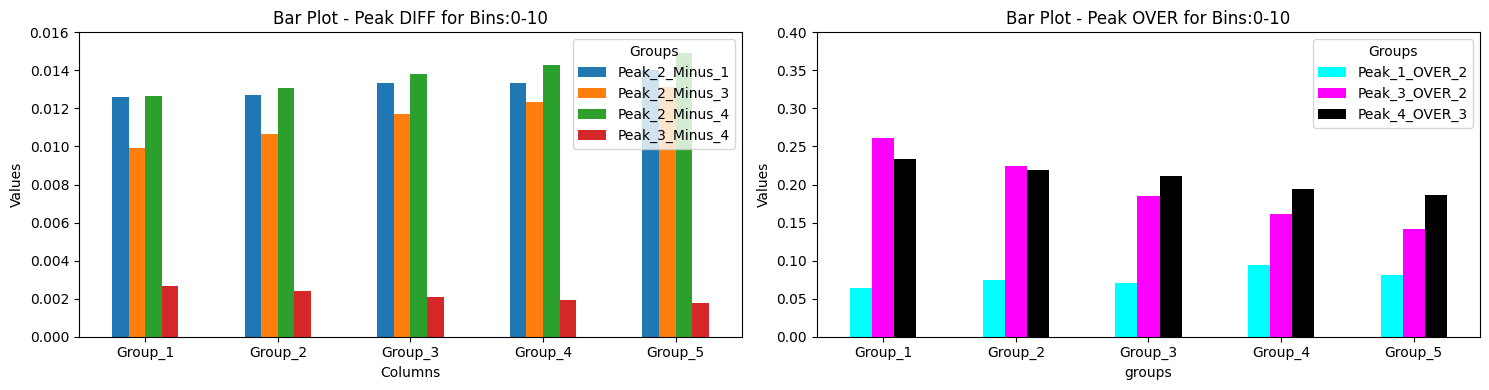

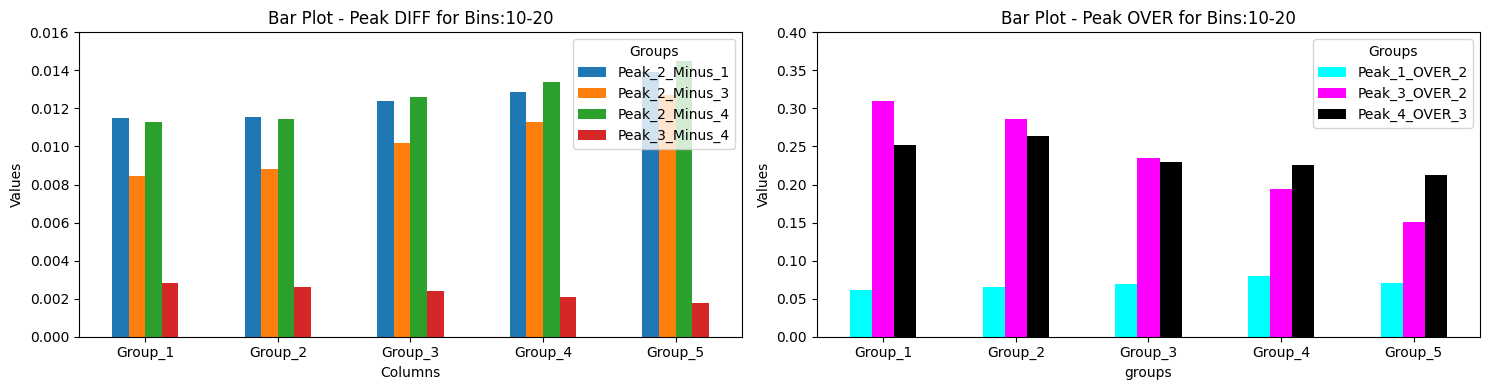

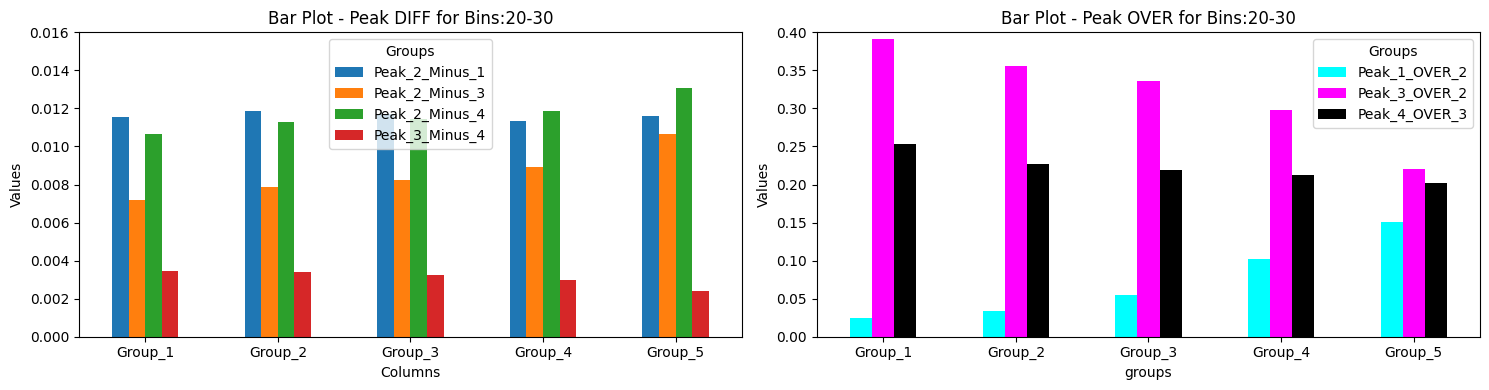

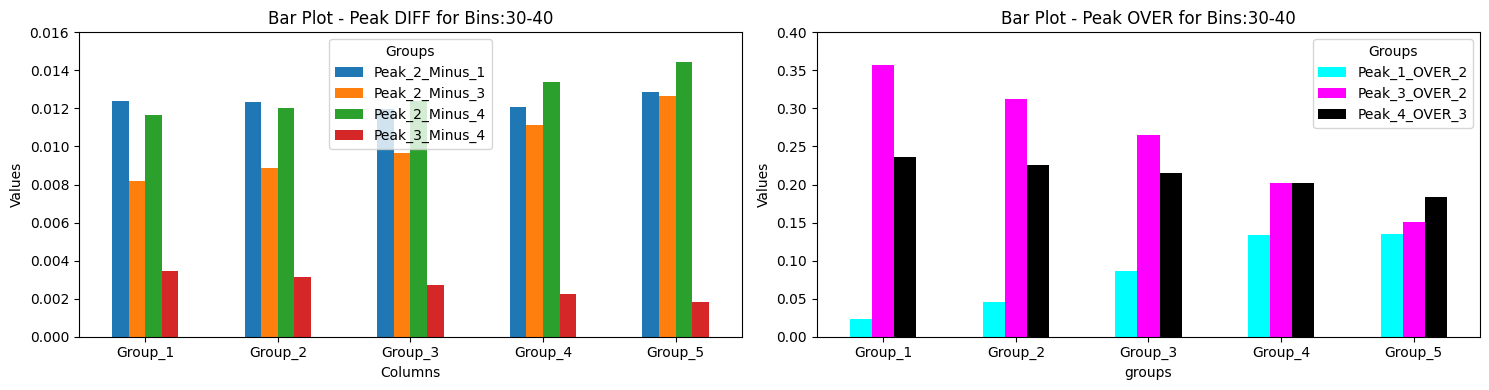

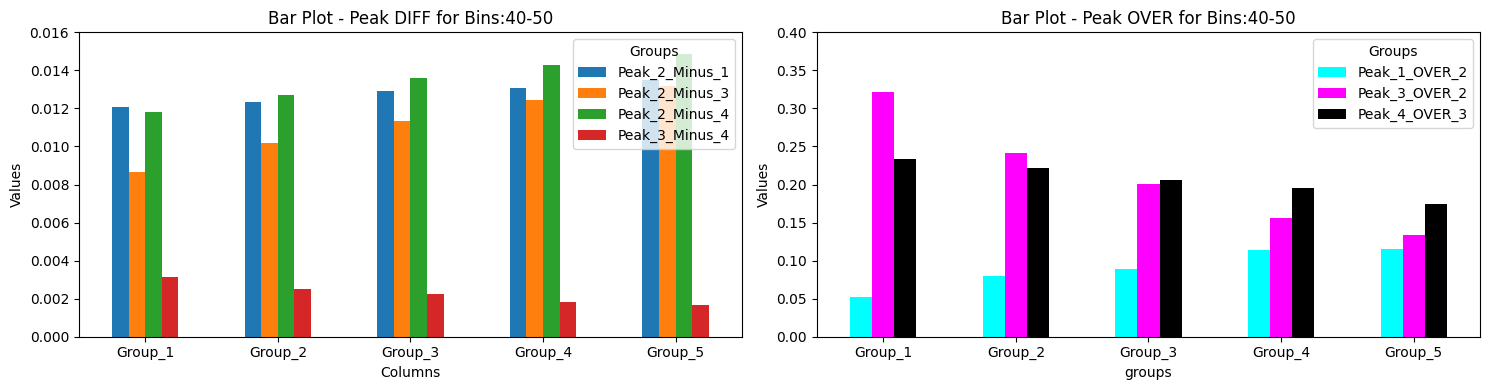

In [96]:
for KK in PeakDiff_Dic:
    df = pd.DataFrame(PeakDiff_Dic[KK])

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    df1 = df[['groups','Peak_2_Minus_1', 'Peak_2_Minus_3', 'Peak_2_Minus_4', 'Peak_3_Minus_4']]
    df1.set_index('groups').plot(kind='bar', ax=axs[0], rot=0)
    axs[0].set_title('Bar Plot - Peak DIFF for ' + KK )
    axs[0].set_xlabel('Columns')
    axs[0].set_ylabel('Values')
    axs[0].legend(title='Groups')
    axs[0].set_ylim(0, 0.016)

    df2 = df[['groups','Peak_1_OVER_2', 'Peak_3_OVER_2', 'Peak_4_OVER_3']]
    df2.set_index('groups').plot(kind='bar', ax=axs[1], rot=0, color= ['cyan','magenta','black'])
    axs[1].set_title('Bar Plot - Peak OVER for ' + KK )
    axs[1].set_ylabel('Values')
    axs[1].legend(title='Groups')
    axs[1].set_ylim(0, 0.4)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()


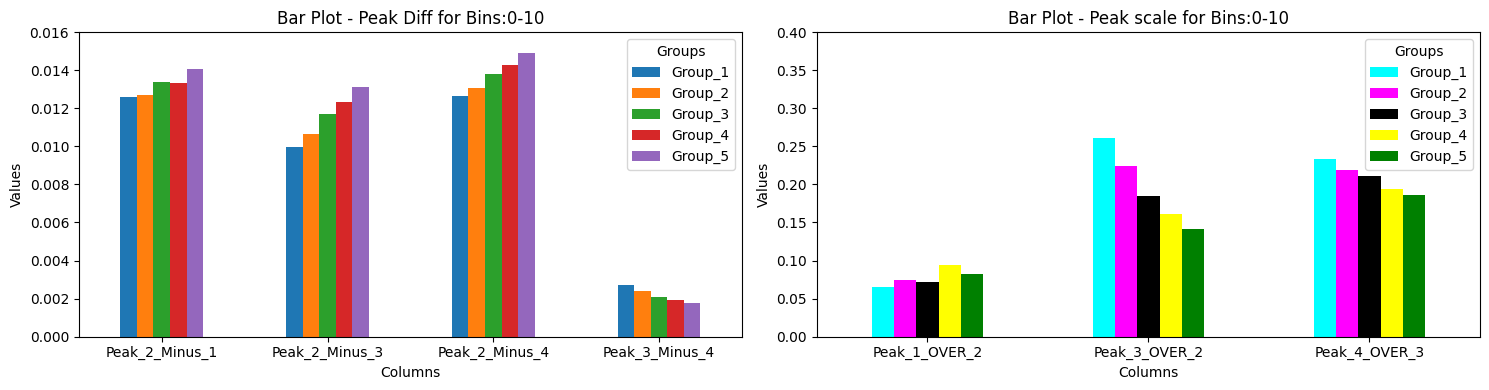

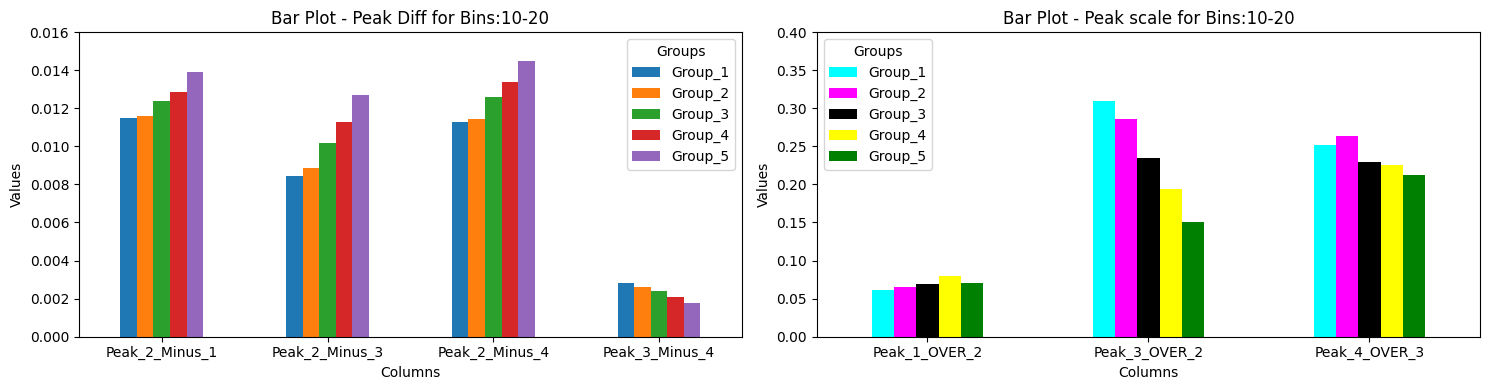

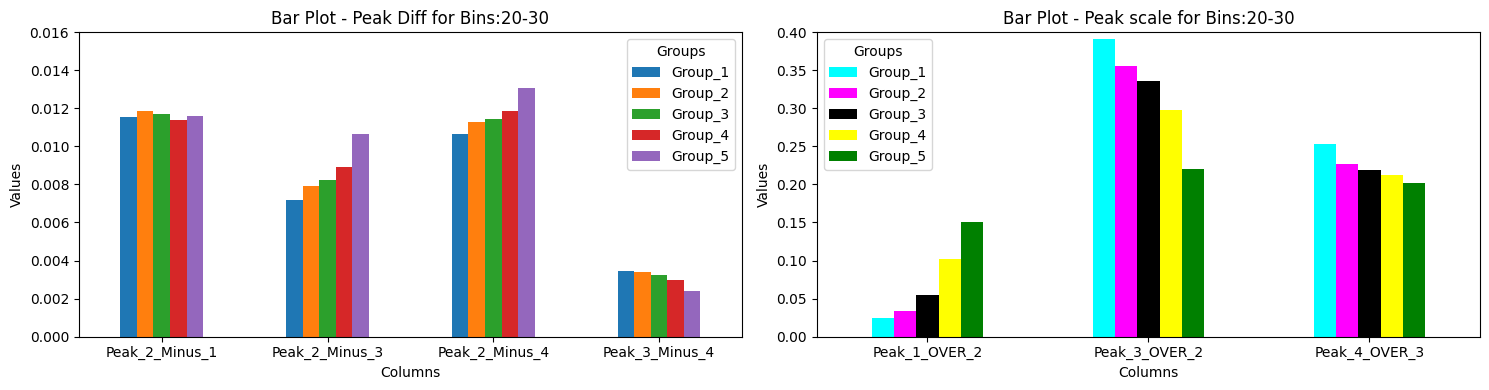

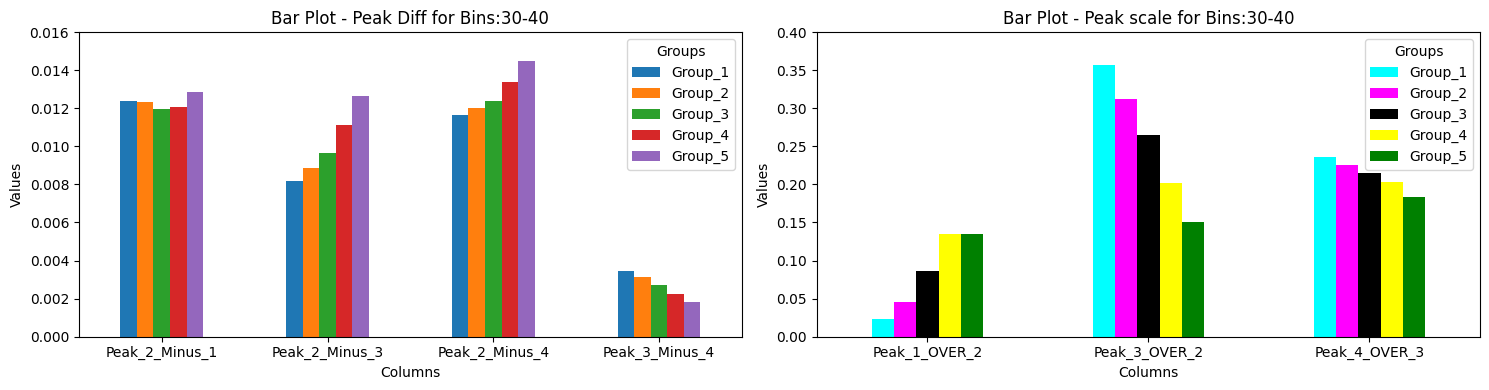

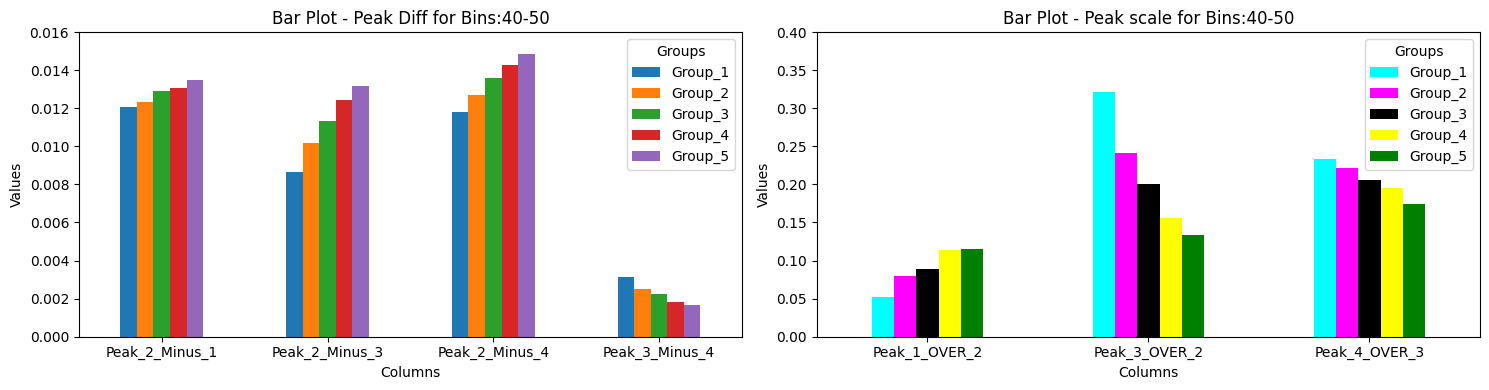

In [97]:

for KK in PeakDiff_Dic:
    df_transposed = pd.DataFrame(PeakDiff_Dic[KK]).set_index('groups').transpose()

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    # Plot the first set of columns ('X1' and 'X2') in the first subplot
    df_transposed[df_transposed.index.isin(['Peak_2_Minus_1', 'Peak_2_Minus_3', 'Peak_2_Minus_4', 'Peak_3_Minus_4'])].plot(kind='bar', ax=axs[0], rot=0)
    axs[0].set_title('Bar Plot - Peak Diff for ' + KK )
    axs[0].set_xlabel('Columns')
    axs[0].set_ylabel('Values')
    axs[0].legend(title='Groups')
    axs[0].set_ylim(0, 0.016)

    # Plot the second set of columns ('X3' and 'X4') in the second subplot
    df_transposed[df_transposed.index.isin(['Peak_1_OVER_2', 'Peak_3_OVER_2', 'Peak_4_OVER_3'])].plot(kind='bar', ax=axs[1], rot=0, color= ['cyan','magenta','black','yellow','green'])
    axs[1].set_title('Bar Plot - Peak scale for ' + KK )
    axs[1].set_xlabel('Columns')
    axs[1].set_ylabel('Values')
    axs[1].legend(title='Groups')
    axs[1].set_ylim(0, 0.4)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()
